In [1]:
import os
import cv2
import torch
import joblib
import timm
import torch.nn as nn
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchmetrics.regression import R2Score
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.models import efficientnet

c:\Users\Shintaro\anaconda3\envs\pytorch-LLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    # model_name = 'tf_efficientnetv2_b2'  # Name of pretrained classifier
    image_size = 224  # Input image size
    epochs = 12 # Training epochs
    batch_size = 20  # Batch size
    lr = 1e-4
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    num_folds = 5 # Number of folds to split the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['X4_mean', 'X11_mean', 'X18_mean',
                   'X26_mean', 'X50_mean', 'X3112_mean',]
    aux_class_names = list(map(lambda x: x.replace("mean","sd"), class_names))
    num_classes = len(class_names)
    aux_num_classes = len(aux_class_names)
    precision = torch.float32

In [38]:
test_df.columns[1:-1].tolist()

['WORLDCLIM_BIO1_annual_mean_temperature',
 'WORLDCLIM_BIO12_annual_precipitation',
 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
 'WORLDCLIM_BIO15_precipitation_seasonality',
 'WORLDCLIM_BIO4_temperature_seasonality',
 'WORLDCLIM_BIO7_temperature_annual_range',
 'SOIL_bdod_0.5cm_mean_0.01_deg',
 'SOIL_bdod_100.200cm_mean_0.01_deg',
 'SOIL_bdod_15.30cm_mean_0.01_deg',
 'SOIL_bdod_30.60cm_mean_0.01_deg',
 'SOIL_bdod_5.15cm_mean_0.01_deg',
 'SOIL_bdod_60.100cm_mean_0.01_deg',
 'SOIL_cec_0.5cm_mean_0.01_deg',
 'SOIL_cec_100.200cm_mean_0.01_deg',
 'SOIL_cec_15.30cm_mean_0.01_deg',
 'SOIL_cec_30.60cm_mean_0.01_deg',
 'SOIL_cec_5.15cm_mean_0.01_deg',
 'SOIL_cec_60.100cm_mean_0.01_deg',
 'SOIL_cfvo_0.5cm_mean_0.01_deg',
 'SOIL_cfvo_100.200cm_mean_0.01_deg',
 'SOIL_cfvo_15.30cm_mean_0.01_deg',
 'SOIL_cfvo_30.60cm_mean_0.01_deg',
 'SOIL_cfvo_5.15cm_mean_0.01_deg',
 'SOIL_cfvo_60.100cm_mean_0.01_deg',
 'SOIL_clay_0.5cm_mean_0.01_deg',
 'SOIL_clay_100.200cm_mean_0.01_d

In [3]:
PATH = '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/Data/planttraits2024'

# Train + Valid
df = pd.read_csv(f'{PATH}/train.csv')
df['image_path'] = f'{PATH}/train_images/'+df['id'].astype(str)+'.jpeg'
df.loc[:, CFG.aux_class_names] = df.loc[:, CFG.aux_class_names].fillna(-1)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{PATH}/test.csv')
test_df['image_path'] = f'{PATH}/test_images/'+test_df['id'].astype(str)+'.jpeg'
FEATURE_COLS = test_df.columns[1:-1].tolist()
display(test_df.head(2))

id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  192027691                               12.235703   
1  195542235                               17.270555   

   WORLDCLIM_BIO12_annual_precipitation  \
0                            374.466675   
1                             90.239998   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                          62.524445                       
1                                          10.351111                       

   WORLDCLIM_BIO15_precipitation_seasonality  \
0                                  72.256844   
1                                  38.220940   

   WORLDCLIM_BIO4_temperature_seasonality  \
0                              773.592041   
1                              859.193298   

   WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                33.277779                            125   
1                                40.009777                            124   

   SOIL_bdod_100.200cm_mean_0.01_deg  SOIL_bdod_15.30cm_mean_0.01_deg  ...  \
0                                149                              136  ...   
1                                144                              138  ...   

   X26_mean  X50_mean  X3112_mean     X4_sd    X11_sd    X18_sd    X26_sd  \
0  1.243779  1.849375   50.216034  0.008921  1.601473  0.025441  0.153608   
1  0.642940  1.353468  574.098472  0.003102  0.258078  0.000866  0.034630   

     X50_sd   X3112_sd                                         image_path  
0  0.279610  15.045054  /Users/Shintaro/Documents/Kaggle-comps/PlantTr...  
1  0.010165  11.004477  /Users/Shintaro/Documents/Kaggle-comps/PlantTr...  

[2 rows x 177 columns]

id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  195066138                                10.55810   
1  195524180                                 7.00287   

   WORLDCLIM_BIO12_annual_precipitation  \
0                            961.500000   
1                           1120.025513   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                          31.586735                       
1                                          23.000000                       

   WORLDCLIM_BIO15_precipitation_seasonality  \
0                                  13.728325   
1                                   7.258863   

   WORLDCLIM_BIO4_temperature_seasonality  \
0                              648.038208   
1                              973.889404   

   WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                25.351532                            127   
1                                39.135712                            106   

   SOIL_bdod_100.200cm_mean_0.01_deg  SOIL_bdod_15.30cm_mean_0.01_deg  ...  \
0                                152                              137  ...   
1                                167                              127  ...   

   VOD_X_1997_2018_multiyear_mean_m04  VOD_X_1997_2018_multiyear_mean_m05  \
0                            0.469694                            0.455849   
1                            0.428838                            0.456266   

   VOD_X_1997_2018_multiyear_mean_m06  VOD_X_1997_2018_multiyear_mean_m07  \
0                            0.528211                            0.555653   
1                            0.470074                            0.468038   

   VOD_X_1997_2018_multiyear_mean_m08  VOD_X_1997_2018_multiyear_mean_m09  \
0                            0.549882                            0.542905   
1                            0.475943                            0.483206   

   VOD_X_1997_2018_multiyear_mean_m10  VOD_X_1997_2018_multiyear_mean_m11  \
0                            0.517507                            0.462724   
1                            0.477197                            0.432732   

   VOD_X_1997_2018_multiyear_mean_m12  \
0                            0.427107   
1                            0.423728   

                                          image_path  
0  /Users/Shintaro/Documents/Kaggle-comps/PlantTr...  
1  /Users/Shintaro/Documents/Kaggle-comps/PlantTr...  

[2 rows x 165 columns]

In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
def build_augmenter():
    # Define Albumentations augmentations
    import random
    transform = A.Compose([
        A.RandomBrightness(limit=0.1, always_apply=False, p=0.4),
        A.RandomContrast(limit=0.1, always_apply=False, p=0.4),
        A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1, val_shift_limit=0.1, p=random.uniform(0, 0.1)),
        A.Cutout(num_holes=1, max_h_size=16, max_w_size=16, always_apply=False, p=random.uniform(0, 0.1)),
        A.HorizontalFlip(p=random.uniform(0, 0.4)),
        A.Rotate(limit=90, p=random.uniform(0, 0.4)),
        A.CenterCrop(height=CFG.image_size, width=CFG.image_size, always_apply=False, p=0.1),
        A.AdvancedBlur(blur_limit=(3,3), sigmaX_limit=(0.1,1.0), sigmaY_limit=(0.1,1.0), rotate_limit=(45), beta_limit=(0.5,8.0), noise_limit=(0.9,1.1), always_apply=False, p = 0.3),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, always_apply=False, p=0.3),
        A.Sharpen(alpha=(0.3,0.5), lightness=(0.5,1.0), always_apply=False, p=random.uniform(0, 0.1)),
        ToTensorV2(),
    ])

    return transform

In [6]:
from PlantDataset import PlantDataset

def build_dataset(paths, features, labels=None, aux_labels=None, batch_size=32, cache=True, augment=True, repeat=True, shuffle=1024, cache_dir="", drop_remainder=False):
    dataset = PlantDataset(paths, features, labels, aux_labels, transform=build_augmenter(), augment=augment)

    if cache_dir != "" and cache:
        os.makedirs(cache_dir, exist_ok=True)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, drop_last=drop_remainder, pin_memory=True)

    return dataloader

In [7]:
from sklearn.model_selection import StratifiedKFold

# Assuming df is your dataframe containing file paths, features, labels, and fold information
skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=42)

# Create separate bin for each trait
for i, trait in enumerate(CFG.class_names):
    bin_edges = np.percentile(df[trait], np.linspace(0, 100, CFG.num_folds + 1))
    df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

df["final_bin"] = df[[f"bin_{i}" for i in range(len(CFG.class_names))]].astype(str).agg("".join, axis=1)

df["fold"] = -1  # Initialize fold column

# Perform the stratified split using final bin
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    df.loc[valid_idx, "fold"] = fold

c:\Users\Shintaro\anaconda3\envs\pytorch-LLM\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [35]:
# Sample from full data
sample_df = df.copy()
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import QuantileTransformer
# Normalize features
minmax = False
if minmax == True:
    #get 0th and 100th percentile to use for the MinMaxScaler
    stds = [list(np.percentile(x.values, q=[0, 100])) for x in [pd.Series(df.loc[:, feat]) for feat in FEATURE_COLS]]
    # train_features = minmax_scale(X=train_df[FEATURE_COLS].values, feature_range=stds, axis=0)
    train_features = []
    valid_features = []
    for idx, (feat, std) in enumerate(zip(FEATURE_COLS, stds)):
        # print(feat)
        train_features.append(minmax_scale(X=train_df[feat].values, feature_range=(std[0], std[1])))
        valid_features.append(minmax_scale(X=valid_df[feat].values, feature_range=(std[0], std[1])))
    train_features = np.array(train_features).T
    valid_features = np.array(valid_features).T
    qt= QuantileTransformer(random_state=42)
    train_features = qt.fit_transform(train_features)
    valid_features = qt.fit_transform(valid_features)
else:
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_df[FEATURE_COLS].values)
    valid_features = scaler.transform(valid_df[FEATURE_COLS].values)
    
    stds = [list(np.percentile(x.values, q=[1, 99])) for x in [pd.Series(df.loc[:, feat]) for feat in CFG.class_names+CFG.aux_class_names]]
    # print(stds)
    # for idx, (feat, std) in enumerate(zip(CFG.class_names, stds)):
    #     train_df[feat] = minmax_scale(X=train_df[feat].values, feature_range=(std[0],std[1]))
    #     valid_df[feat] = minmax_scale(X=valid_df[feat].values, feature_range=(std[0],std[1]))
    for _, (feat, (lower, upper)) in enumerate(zip(CFG.class_names+CFG.aux_class_names, stds)):
        # print(f'lower: {lower} | upper: {upper}')
        train_df[feat].clip(lower=lower, upper=upper, inplace=True)
        valid_df[feat].clip(lower=lower, upper=upper, inplace=True)
        
# train_features = train_df[FEATURE_COLS].values
# valid_features = valid_df[FEATURE_COLS].values

# Num Train: 44391 | Num Valid: 11098


C:\Users\Shintaro\AppData\Local\Temp\ipykernel_28200\1094467879.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[feat].clip(lower=lower, upper=upper, inplace=True)
C:\Users\Shintaro\AppData\Local\Temp\ipykernel_28200\1094467879.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[feat].clip(lower=lower, upper=upper, inplace=True)


In [36]:
train_df[CFG.class_names].describe()

X4_mean      X11_mean      X18_mean      X26_mean      X50_mean  \
count  44391.000000  44391.000000  44391.000000  44391.000000  44391.000000   
mean       0.522942     16.029181      3.409873     49.688374      1.631341   
std        0.148018      8.321151      5.758946    184.629306      0.701534   
min        0.227442      3.074351      0.041209      0.010774      0.492031   
25%        0.410739     10.635603      0.309987      0.559514      1.174045   
50%        0.509275     15.120035      0.717123      2.529542      1.480130   
75%        0.622427     19.687053      3.574691     14.983956      1.924787   
max        0.920609     50.827982     28.523696   1395.932956      4.464096   

         X3112_mean  
count  44391.000000  
mean    2046.341614  
std     3717.720991  
min       11.277231  
25%      255.280663  
50%      725.826602  
75%     2158.051648  
max    24539.716806

In [26]:
means = [0.522942,	16.029181,	3.409873,	49.688374,	1.631341,	2046.341614]
vals = train_df[CFG.class_names].iloc[0].values
res = (vals > means)
print(vals)
print(means)
print(res)

[ 0.40175312 11.7581081   0.1174843   1.24377911  1.84937541 50.21603412]
[0.522942, 16.029181, 3.409873, 49.688374, 1.631341, 2046.341614]
[False False False False  True False]


In [37]:
train_df[CFG.aux_class_names].describe()

X4_sd        X11_sd        X18_sd        X26_sd        X50_sd  \
count  44391.000000  44391.000000  44391.000000  44391.000000  44391.000000   
mean      -0.289533      0.408319     -0.000840      3.943517     -0.244896   
std        0.459361      1.546614      0.940583     19.304216      0.494201   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.003569      0.200318      0.037704      0.058750      0.019375   
75%        0.006348      0.606467      0.177772      0.649884      0.052537   
max        0.053755      7.412184      4.240543    158.643594      0.468160   

           X3112_sd  
count  44391.000000  
mean     211.130200  
std      598.995500  
min       -1.000000  
25%       -1.000000  
50%       21.650212  
75%      128.676705  
max     4353.353343

In [16]:
# Extract file paths, features, labels, and fold information for train and validation sets
train_paths = train_df.image_path.values
train_labels = train_df[CFG.class_names].values
train_aux_labels = train_df[CFG.aux_class_names].values

valid_paths = valid_df.image_path.values
valid_labels = valid_df[CFG.class_names].values
valid_aux_labels = valid_df[CFG.aux_class_names].values

# Build datasets
train_dataloader = build_dataset(train_paths, train_features, train_labels, train_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=False)
valid_dataloader = build_dataset(valid_paths, valid_features, valid_labels, valid_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

NameError: name 'build_dataset' is not defined

In [ ]:
inps, tars = next(iter(train_dataloader))
imgs = inps["images"]
print(inps['features'])

KeyboardInterrupt: 

tensor([[4.3613e+00, 9.5065e+02, 3.2508e+01, 1.5274e+01, 3.7572e+02, 1.8589e+01,
         8.1000e+01, 1.1800e+02, 1.0000e+02, 1.0900e+02, 8.8000e+01, 1.1500e+02,
         3.2600e+02, 2.2000e+02, 2.5300e+02, 2.3100e+02, 2.7000e+02, 2.1500e+02,
         1.3100e+02, 2.3900e+02, 1.7000e+02, 1.9943e+02, 1.5700e+02, 2.2800e+02,
         1.7600e+02, 1.7500e+02, 1.6700e+02, 1.6700e+02, 1.7325e+02, 1.7200e+02,
         9.1800e+02, 4.3800e+02, 5.6800e+02, 4.4300e+02, 8.8800e+02, 4.1700e+02,
         6.2559e+02, 3.5600e+02, 4.4300e+02, 3.3800e+02, 5.7755e+02, 3.4300e+02,
         1.2600e+02, 5.7000e+01, 6.0000e+01, 5.8000e+01, 5.9000e+01, 5.8000e+01,
         6.0000e+01, 5.7400e+02, 6.0300e+02, 5.9300e+02, 5.9700e+02, 5.7300e+02,
         6.0300e+02, 2.4900e+02, 2.1989e+02, 2.4100e+02, 2.3700e+02, 2.5300e+02,
         2.2400e+02, 1.6590e+03, 8.3900e+02, 1.1020e+03, 8.9100e+02, 1.4730e+03,
         9.7200e+02, 5.4500e+02, 1.5337e+03, 3.0300e+02, 5.1219e+02, 1.5092e+03,
         1.0807e+03, 1.5326e

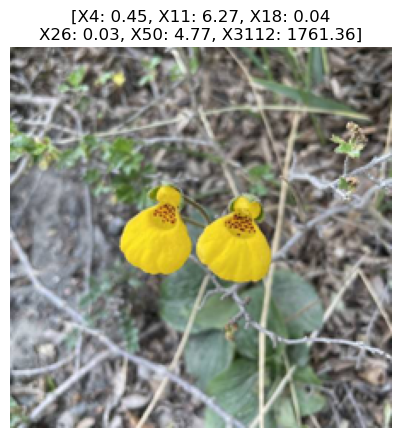

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PlantDataset import PlantDataset

# Get a batch of data
inps, tars = next(iter(train_dataloader))
imgs = inps["images"]
print(inps['features'])
num_imgs, num_cols = 8, 4

# Convert PyTorch tensors to NumPy arrays
imgs_np = imgs.numpy()
tars_np = tars[0].numpy()

plt.figure(figsize=(4 * num_cols, num_imgs // num_cols * 5))

for i, (img, tar) in enumerate(zip(imgs_np[:num_imgs], tars_np[:num_imgs])):
    plt.subplot(num_imgs // num_cols, num_cols, i + 1)

    # Normalize the image to [0, 1]
    img = (img - img.min()) / (img.max() - img.min() + 1e-4)

    formatted_tar = "\n".join(
        [
            ", ".join(
                f"{name.replace('_mean','')}: {val:.2f}"
                for name, val in zip(CFG.class_names[j : j + 3], tar[j : j + 3])
            )
            for j in range(0, len(CFG.class_names), 3)
        ]
    )

    plt.imshow(img.transpose(1, 2, 0))  # Transpose to (height, width, channels)
    plt.title(f"[{formatted_tar}]")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
#cube_padding = (33*33) - cube_size*cube_size
#input dims: (6(num_sides), cub_size+cube_padding(6,33*2,33*3), max_move_num(99))
#output dims: (1, num_moves+move_padding)
class cube_CNN(nn.Module):
    def __init__(self, num_classes, aux_num_classes, feature_cols):
        super(cube_CNN, self).__init__()
        
        self.sqr5_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=(7,7))
        #batch32
        self.pool3 = nn.AvgPool2d((3,3), stride=3)
        self.sqr5_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=(5,5))
        
        self.sqr5_conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=(6,6))
        #bacth32
        #pool3
        self.sqr5_conv4 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1,1))
        
        self.sqr5_conv5 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(5,5), padding=(8,8))
        #batch64
        #pool3
        self.sqr5_conv6 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1,1))
        
        self.sqr5_conv7 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), padding=(8,8))
        #batch16
        self.pool5 = nn.AvgPool2d((5,5), stride=3)
        self.sqr5_conv8 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1,1))
        
        self.sqr5_conv9 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(5,5), padding=(10,10))
        #batch256
        #pool5
        self.sqr5_conv10 = nn.Conv2d(in_channels=256, out_channels=2048, kernel_size=(1,1))
        
        self.sqr5_conv11 = nn.Conv2d(in_channels=2048, out_channels=4096, kernel_size=(3,3), padding=(6,6))
        #batch4096
        #pool3
        self.sqr5_conv12 = nn.Conv2d(in_channels=4096, out_channels=2048, kernel_size=(1,1))
        
        self.sqr5_conv13 = nn.Conv2d(in_channels=2048, out_channels=256, kernel_size=(5,5), padding=(10,10))
        #batch256
        #pool5
        self.sqr5_conv14 = nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=(1,1))
        
        self.sqr5_conv15 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=(3,3), padding=(6,6))
        #bacth2048
        #pool3
        self.sqr5_conv16 = nn.Conv2d(in_channels=2048, out_channels=256, kernel_size=(1,1))
        
        self.sqr5_conv17 = nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=(5,5), padding=(8,8))
        #batch1024
        #pool3
        self.sqr5_conv18 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=(1,1))
        
        self.sqr5_conv19 = nn.Conv2d(in_channels=256, out_channels=2048, kernel_size=(1,1))
        self.sqr5_conv20 = nn.Conv2d(in_channels=2048, out_channels=256, kernel_size=(1,1), padding=(1,1))
        #batch256
        #pool3
        self.sqr5_conv21 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(1,1))
        self.sqr5_conv22 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1,1))
        
        self.batchn16 = nn.BatchNorm2d(16)
        self.batchn32 = nn.BatchNorm2d(32)
        self.batchn64 = nn.BatchNorm2d(64)
        self.batchn128 = nn.BatchNorm2d(128)
        self.batchn256 = nn.BatchNorm2d(256)
        self.batchn1024 = nn.BatchNorm2d(1024)
        self.btachn2048 = nn.BatchNorm2d(2048)
        self.btachn4096 = nn.BatchNorm2d(4096)
        # self.batchn4 = nn.BatchNorm2d(1)
        # self.batchn5 = nn.BatchNorm2d(1)
        in_size = 256 #163
        self.out_conv_nn1 = nn.Linear(in_size, 256)
        self.out_conv_nn2 = nn.Linear(256, 64)
        self.out_conv_nn3 = nn.Linear(64,32)
        self.out_conv_nn4 = nn.Linear(32, 163)
        
        
        self.conv_dropout = nn.Dropout(0.1)
        #input for this layer will be torch.concat(horiz_conv, vert_conv.T)
        # self.inconv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=(4,4))
        
        self.conv_feat1 = nn.Linear(163*2, 256)
        self.batchnn1d1 = nn.BatchNorm1d(256)
        self.conv_feat2 = nn.Linear(256, 32)
        self.batchnn1d2 = nn.BatchNorm1d(32)
        self.conv_feat_out = nn.Linear(32, 6)
        self.conv_feat_out_aux = nn.Linear(32, 6)
        
        self.fc_dropout = nn.Dropout(0.1)
        
        
    def forward(self, img, feature):

        
        sqr5_conv = self.conv_dropout(self.pool3(self.batchn32(self.sqr5_conv1(img))))
        sqr5_conv = self.conv_dropout(self.pool5(self.sqr5_conv2(sqr5_conv)))

        sqr5_conv = self.pool3(self.batchn32(self.sqr5_conv3(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv4(sqr5_conv))
        
        sqr5_conv = self.pool3(self.batchn64(self.sqr5_conv5(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv6(sqr5_conv))

        sqr5_conv = self.pool5(self.batchn16(self.sqr5_conv7(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv8(sqr5_conv))
        
        sqr5_conv = self.pool5(self.batchn256(self.sqr5_conv9(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv10(sqr5_conv))
        
        sqr5_conv = self.pool3(self.btachn4096(self.sqr5_conv11(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv12(sqr5_conv))
        
        sqr5_conv = self.pool5(self.batchn256(self.sqr5_conv13(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv14(sqr5_conv))
        
        sqr5_conv = self.pool3(self.btachn2048(self.sqr5_conv15(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv16(sqr5_conv))
        
        sqr5_conv = self.pool3(self.batchn1024(self.sqr5_conv17(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv18(sqr5_conv))
        sqr5_conv = self.conv_dropout(self.sqr5_conv19(sqr5_conv))
        
        sqr5_conv = self.pool3(self.batchn256(self.sqr5_conv20(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv21(sqr5_conv))
        sqr5_conv = self.conv_dropout(self.sqr5_conv22(sqr5_conv))
        
        # print(sqr5_conv.size())
        b = sqr5_conv.size()[0]
        sqr5_flat = torch.reshape(sqr5_conv, (b,-1))
        lin_conv = self.fc_dropout(self.out_conv_nn1(sqr5_flat))
        lin_conv = self.out_conv_nn2(lin_conv)
        lin_conv = self.fc_dropout(self.out_conv_nn3(lin_conv))
        lin_conv = self.out_conv_nn4(lin_conv)

        conv_feat_x = torch.concat([lin_conv, feature], dim=1)
        
        conv_feat_x = self.fc_dropout(self.batchnn1d1(self.conv_feat1(conv_feat_x)))
        conv_feat_x = self.batchnn1d2(self.conv_feat2(conv_feat_x))
        out = self.conv_feat_out(conv_feat_x)
        aux_out = self.conv_feat_out_aux(conv_feat_x)

        return {'out':out, 'aux_out':aux_out}

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
#cube_padding = (33*33) - cube_size*cube_size
#input dims: (6(num_sides), cub_size+cube_padding(6,33*2,33*3), max_move_num(99))
#output dims: (1, num_moves+move_padding)
class cube_CNN(nn.Module):
    def __init__(self, num_classes, aux_num_classes, feature_cols):
        super(cube_CNN, self).__init__()
        
        self.sqr5_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=(7,7))
        #batch32
        self.pool3 = nn.AvgPool2d((3,3), stride=3)
        self.sqr5_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=(5,5))
        
        self.sqr5_conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=(6,6))
        #bacth32
        #pool3
        self.sqr5_conv4 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1,1))
        
        self.sqr5_conv5 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(5,5), padding=(8,8))
        #batch64
        #pool3
        self.sqr5_conv6 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1,1))
        
        self.sqr5_conv7 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), padding=(8,8))
        #batch16
        self.pool5 = nn.AvgPool2d((5,5), stride=3)
        self.sqr5_conv8 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1,1))
        
        self.sqr5_conv9 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(5,5), padding=(10,10))
        #batch256
        #pool5
        
        self.sqr5_conv10 = nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=(1,1))
        self.sqr5_conv11 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=(1,1))
        
        self.sqr5_conv12 = nn.Conv2d(in_channels=2048, out_channels=4096, kernel_size=(1,1))
        self.sqr5_conv13 = nn.Conv2d(in_channels=4096, out_channels=2048, kernel_size=(1,1), padding=(1,1))
        #batch2048
        #pool3
        self.sqr5_conv14 = nn.Conv2d(in_channels=2048, out_channels=128, kernel_size=(1,1))
        self.sqr5_conv15 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1,1))
        
        self.batchn16 = nn.BatchNorm2d(16)
        self.batchn32 = nn.BatchNorm2d(32)
        self.batchn64 = nn.BatchNorm2d(64)
        self.batchn128 = nn.BatchNorm2d(128)
        self.batchn256 = nn.BatchNorm2d(256)
        self.batchn1024 = nn.BatchNorm2d(1024)
        self.batchn2048 = nn.BatchNorm2d(2048)
        # self.btachn4096 = nn.BatchNorm2d(4096)
        # self.batchn4 = nn.BatchNorm2d(1)
        # self.batchn5 = nn.BatchNorm2d(1)
        in_size = 256 #163
        self.out_conv_nn1 = nn.Linear(in_size, 256)
        self.out_conv_nn2 = nn.Linear(256, 64)
        self.out_conv_nn3 = nn.Linear(64,32)
        self.out_conv_nn4 = nn.Linear(32, 163)
        
        
        self.conv_dropout = nn.Dropout(0.1)
        #input for this layer will be torch.concat(horiz_conv, vert_conv.T)
        # self.inconv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=(4,4))
        
        self.conv_feat1 = nn.Linear(163*2, 256)
        self.batchnn1d1 = nn.BatchNorm1d(256)
        self.conv_feat2 = nn.Linear(256, 32)
        self.batchnn1d2 = nn.BatchNorm1d(32)
        self.conv_feat_out = nn.Linear(32, 6)
        self.conv_feat_out_aux = nn.Linear(32, 6)
        
        self.fc_dropout = nn.Dropout(0.1)
        
        
    def forward(self, img, feature):

        
        sqr5_conv = self.conv_dropout(self.pool3(self.batchn32(self.sqr5_conv1(img))))
        sqr5_conv = self.conv_dropout(self.pool5(self.sqr5_conv2(sqr5_conv)))

        sqr5_conv = self.pool3(self.batchn32(self.sqr5_conv3(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv4(sqr5_conv))
        
        sqr5_conv = self.pool3(self.batchn64(self.sqr5_conv5(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv6(sqr5_conv))

        sqr5_conv = self.pool5(self.batchn16(self.sqr5_conv7(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv8(sqr5_conv))
        
        sqr5_conv = self.pool5(self.batchn256(self.sqr5_conv9(sqr5_conv)))

        sqr5_conv = self.conv_dropout(self.sqr5_conv10(sqr5_conv))
        sqr5_conv = self.conv_dropout(self.sqr5_conv11(sqr5_conv))
        sqr5_conv = self.conv_dropout(self.sqr5_conv12(sqr5_conv))
        
        sqr5_conv = self.pool3(self.batchn2048(self.sqr5_conv13(sqr5_conv)))
        sqr5_conv = self.conv_dropout(self.sqr5_conv14(sqr5_conv))
        sqr5_conv = self.conv_dropout(self.sqr5_conv15(sqr5_conv))
        
        # print(sqr5_conv.size())
        b = sqr5_conv.size()[0]
        sqr5_flat = torch.reshape(sqr5_conv, (b,-1))
        lin_conv = self.fc_dropout(self.out_conv_nn1(sqr5_flat))
        lin_conv = self.out_conv_nn2(lin_conv)
        lin_conv = self.fc_dropout(self.out_conv_nn3(lin_conv))
        lin_conv = self.out_conv_nn4(lin_conv)

        conv_feat_x = torch.concat([lin_conv, feature], dim=1)
        
        conv_feat_x = self.fc_dropout(self.batchnn1d1(self.conv_feat1(conv_feat_x)))
        conv_feat_x = self.batchnn1d2(self.conv_feat2(conv_feat_x))
        out = self.conv_feat_out(conv_feat_x)
        aux_out = self.conv_feat_out_aux(conv_feat_x)

        return {'out':out, 'aux_out':aux_out}

In [ ]:
#CNNF MODEL

import torch.nn as nn
import torch
import torch.nn.functional as F
from typing import Any, cast, Dict, List, Optional, Union
#cube_padding = (33*33) - cube_size*cube_size
#input dims: (6(num_sides), cub_size+cube_padding(6,33*2,33*3), max_move_num(99))
#output dims: (1, num_moves+move_padding)
class CNNF(nn.Module):
    def __init__(self, features: nn.Module, num_classes: int = 6, dropout_fc: float = 0.1, adapt_size: List[int] = [9,9], conv_outsize: int = 512, include_features:bool = False):
        super(CNNF, self).__init__()
        self.features = features
        self.adpavgp = nn.AdaptiveAvgPool2d((adapt_size[0],adapt_size[1]))
        self.include_features = include_features
        self.feature_outsize = 1024 if include_features else 0
        gelu_approx = 'tanh'
        if include_features:
            self.feature_nn = nn.Sequential(
                nn.Linear(163, 1024),
                nn.GELU(approximate=gelu_approx),
                nn.Dropout(p=dropout_fc),
                nn.Linear(1024, 256),
                nn.GELU(approximate=gelu_approx),
                nn.Dropout(p=dropout_fc),
                nn.Linear(256, self.feature_outsize),
            )
            self.aux_classifier = nn.Sequential(
                nn.Linear((conv_outsize*adapt_size[0]*adapt_size[1]) + self.feature_outsize, 2048),
                nn.GELU(approximate=gelu_approx),
                nn.Dropout(p=dropout_fc),
                nn.Linear(2048, 1024),
                nn.GELU(approximate=gelu_approx),
                nn.Dropout(p=dropout_fc),
                nn.Linear(1024, 256),
                nn.GELU(approximate=gelu_approx),
                nn.Dropout(p=dropout_fc),
                nn.Linear(256, num_classes)
            )
        
        #Maybe later add deeper connection between aux_classifier and classifier
        
        self.classifier = nn.Sequential(
            nn.Linear((conv_outsize*adapt_size[0]*adapt_size[1]) + self.feature_outsize, 4096),
            nn.GELU(approximate=gelu_approx),
            nn.Dropout(p=dropout_fc),
            nn.Linear(4096, 4096),
            nn.GELU(approximate=gelu_approx),
            nn.Dropout(p=dropout_fc),
            nn.Linear(4096, 2048),
            nn.GELU(approximate=gelu_approx),
            nn.Dropout(p=dropout_fc),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, img:torch.Tensor, feature:torch.Tensor) -> torch.Tensor:
        img = self.features(img)
        img = self.adpavgp(img)
        img = torch.flatten(img, 1)
        
        if self.include_features:
            feature = self.feature_nn(feature)
            class_x = torch.concat([img, feature], dim=1)
        else:
            class_x = img
        out = self.classifier(class_x)
        
        if self.include_features:
            aux_out = self.aux_classifier(class_x)
        else:
            aux_out = None
        return out, aux_out


def make_layers(cfg: List[Union[str,int]], batch_norm:bool = False, dropout: float = 0.1, outsize: int = 512, max_kernel_size: int = 3, calc_padding: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    reversed = False
    inc = 0
    if reversed:
        kernel_size = max_kernel_size
    else:
        kernel_size = 3
    for v in cfg[:-1]:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, padding=1 if calc_padding else 0)]
        elif v == "A":
            layers += [nn.AvgPool2d(kernel_size=2, stride=2, padding=1 if calc_padding else 0)]
        elif v == "k+":
            inc += 2
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels=in_channels, out_channels=v, kernel_size=kernel_size+inc, padding=kernel_size+inc if calc_padding else 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True), nn.Dropout2d(p=dropout)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True), nn.Dropout2d(p=dropout)]
                
            in_channels = v
            #change kernel size to be either max if its 3 or subtract 2 to next smallest kernel size
            if reversed:
                kernel_size = max_kernel_size if kernel_size == 3 else kernel_size - 2
            else:
                kernel_size = 3 if kernel_size == max_kernel_size else kernel_size + 2
            
            if inc > 0:
                inc = 0
                
                
            
    conv2d = nn.Conv2d(in_channels=in_channels, out_channels=outsize, kernel_size=kernel_size, padding=kernel_size if calc_padding else 1)
    if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(outsize), nn.ReLU(inplace=True), nn.Dropout2d(p=dropout)]
    else:
        layers += [conv2d, nn.ReLU(inplace=True), nn.Dropout2d(p=dropout)]
        
    v = cfg[-1]
    if v == "M":
        layers += [nn.MaxPool2d(kernel_size=2, stride=2, padding=1 if calc_padding else 0)]
    elif v == "A":
        layers += [nn.AvgPool2d(kernel_size=2, stride=2, padding=1 if calc_padding else 0)]

    return nn.Sequential(*layers)



In [ ]:
#CNN transformer MODEL

import torch.nn as nn
import torch
import torch.nn.functional as F
from typing import Any, cast, Dict, List, Optional, Union, Callable, OrderedDict
from functools import partial
import math
# from ..ops.misc import Conv2dNormActivation, MLP

class MLP(torch.nn.Sequential):
    """This block implements the multi-layer perceptron (MLP) module.

    Args:
        in_channels (int): Number of channels of the input
        hidden_channels (List[int]): List of the hidden channel dimensions
        norm_layer (Callable[..., torch.nn.Module], optional): Norm layer that will be stacked on top of the linear layer. If ``None`` this layer won't be used. Default: ``None``
        activation_layer (Callable[..., torch.nn.Module], optional): Activation function which will be stacked on top of the normalization layer (if not None), otherwise on top of the linear layer. If ``None`` this layer won't be used. Default: ``torch.nn.ReLU``
        inplace (bool, optional): Parameter for the activation layer, which can optionally do the operation in-place.
            Default is ``None``, which uses the respective default values of the ``activation_layer`` and Dropout layer.
        bias (bool): Whether to use bias in the linear layer. Default ``True``
        dropout (float): The probability for the dropout layer. Default: 0.0
    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: List[int],
        norm_layer: Optional[Callable[..., torch.nn.Module]] = None,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        inplace: Optional[bool] = None,
        bias: bool = True,
        dropout: float = 0.0,
    ):
        # The addition of `norm_layer` is inspired from the implementation of TorchMultimodal:
        # https://github.com/facebookresearch/multimodal/blob/5dec8a/torchmultimodal/modules/layers/mlp.py
        params = {} if inplace is None else {"inplace": inplace}

        layers = []
        in_dim = in_channels
        for hidden_dim in hidden_channels[:-1]:
            layers.append(torch.nn.Linear(in_dim, hidden_dim, bias=bias))
            if norm_layer is not None:
                layers.append(norm_layer(hidden_dim))
            layers.append(activation_layer(**params))
            layers.append(torch.nn.Dropout(dropout, **params))
            in_dim = hidden_dim

        layers.append(torch.nn.Linear(in_dim, hidden_channels[-1], bias=bias))
        layers.append(torch.nn.Dropout(dropout, **params))

        super().__init__(*layers)
        # _log_api_usage_once(self)
        
class MLPBlock(MLP):
    """Transformer MLP block."""

    _version = 2

    def __init__(self, in_dim: int, mlp_dim: int, dropout: float):
        super().__init__(in_dim, [mlp_dim, in_dim], activation_layer=nn.GELU, inplace=None, dropout=dropout)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)

    def _load_from_state_dict(
        self,
        state_dict,
        prefix,
        local_metadata,
        strict,
        missing_keys,
        unexpected_keys,
        error_msgs,
    ):
        version = local_metadata.get("version", None)

        if version is None or version < 2:
            # Replacing legacy MLPBlock with MLP. See https://github.com/pytorch/vision/pull/6053
            for i in range(2):
                for type in ["weight", "bias"]:
                    old_key = f"{prefix}linear_{i+1}.{type}"
                    new_key = f"{prefix}{3*i}.{type}"
                    if old_key in state_dict:
                        state_dict[new_key] = state_dict.pop(old_key)

        super()._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            strict,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )


class EncoderBlock(nn.Module):
    """Transformer encoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=attention_dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.ln_2 = norm_layer(hidden_dim)
        self.mlp = MLPBlock(hidden_dim, mlp_dim, dropout)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        x = self.ln_1(input)
        x, _ = self.self_attention(x, x, x, need_weights=False)
        x = self.dropout(x)
        x = x + input

        y = self.ln_2(x)
        y = self.mlp(y)
        return x + y


class Encoder(nn.Module):
    """Transformer Model Encoder for sequence to sequence translation."""

    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        # Note that batch_size is on the first dim because
        # we have batch_first=True in nn.MultiAttention() by default
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_dim).normal_(std=0.02))  # from BERT
        self.dropout = nn.Dropout(dropout)
        layers: OrderedDict[str, nn.Module] = OrderedDict()
        for i in range(num_layers):
            layers[f"encoder_layer_{i}"] = EncoderBlock(
                num_heads,
                hidden_dim,
                mlp_dim,
                dropout,
                attention_dropout,
                norm_layer,
            )
        self.layers = nn.Sequential(layers)
        self.ln = norm_layer(hidden_dim)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        input = input + self.pos_embedding
        return self.ln(self.layers(self.dropout(input)))


#cube_padding = (33*33) - cube_size*cube_size
#input dims: (6(num_sides), cub_size+cube_padding(6,33*2,33*3), max_move_num(99))
#output dims: (1, num_moves+move_padding)
class CNNVit(nn.Module):
    def __init__(self,  image_size:int, 
                 patch_size:float, 
                 num_layers:int, 
                 num_heads:int, 
                 hidden_dim:int, 
                 mlp_dim:int, 
                 features: nn.Module, 
                 norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6), 
                 num_classes: int = 6, 
                 dropout_fc: float = 0.1, 
                 dropout_enc:float = 0.1, 
                 dropout_atten:float = 0.1, 
                 adapt_size: List[int] = [9,9], 
                 conv_outsize: int = 512, 
                 include_features:bool = False,
                 representation_size:Optional[int] = None):
        super(CNNVit, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_layer = num_layers
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        self.representation_size = representation_size
        self.norm_layer = norm_layer
        
        
        self.adpavgp = nn.AdaptiveAvgPool2d((adapt_size[0],adapt_size[1]))
        self.features = features
        self.include_features = include_features
        self.feature_outsize = 2 if include_features else 1
        
        seq_length = int((image_size // patch_size)**2)
        # print(seq_length)
        self.class_token = nn.Parameter(torch.zeros(1,1,hidden_dim))
        seq_length += 1
        
        self.encoder = Encoder(seq_length=seq_length, 
                               num_layers=num_layers, 
                               num_heads=num_heads,
                               hidden_dim=hidden_dim, 
                               mlp_dim=mlp_dim, 
                               dropout=dropout_enc, 
                               attention_dropout=dropout_atten,
                               norm_layer=norm_layer)
        
        self.seq_length = seq_length
        
        
        heads_layers: OrderedDict[str, nn.Module] = OrderedDict()
        
        heads_layers["pre_logits"] = nn.Linear(hidden_dim, representation_size)
        heads_layers["act"] = nn.Tanh()
        heads_layers["head"] = nn.Linear(representation_size, 512)

        self.heads = nn.Sequential(heads_layers)
        
        heads_con_layers: OrderedDict[str, nn.Module] = OrderedDict()
        
        heads_con_layers["pre_logits"] = nn.Linear(hidden_dim+512, representation_size)
        heads_con_layers["act"] = nn.Tanh()
        heads_con_layers["head"] = nn.Linear(representation_size, 512)

        self.heads_con = nn.Sequential(heads_con_layers)
        
        heads_layers_out: OrderedDict[str, nn.Module] = OrderedDict()
        
        heads_layers_out["pre_logits"] = nn.Linear(512+512, representation_size)
        heads_layers_out["act"] = nn.Tanh()
        heads_layers_out["head"] = nn.Linear(representation_size, num_classes)
        
        self.heads_out = nn.Sequential(heads_layers_out)
        
        if include_features:
            self.feature_nn = nn.Sequential(
                nn.Linear(163, 1024),
                nn.ReLU(True),
                nn.Dropout(p=dropout_fc),
                nn.Linear(1024, 256),
                nn.ReLU(True),
                nn.Dropout(p=dropout_fc),
                nn.Linear(256, 512),
            )
        
        if isinstance(self.features, nn.Conv2d):
            # Init the patchify stem
            fan_in = self.features.in_channels * self.features.kernel_size[0] * self.features.kernel_size[1]
            nn.init.trunc_normal_(self.features.weight, std=math.sqrt(1 / fan_in))
            if self.features.bias is not None:
                nn.init.zeros_(self.features.bias)
        elif self.features[-1] is not None and isinstance(self.features[-1], nn.Conv2d):
            # Init the last 1x1 conv of the conv stem
            nn.init.normal_(
                self.features[-1].weight, mean=0.0, std=math.sqrt(2.0 / self.features[-1].out_channels)
            )
            if self.features[-1].bias is not None:
                nn.init.zeros_(self.features[-1].bias)

        if hasattr(self.heads, "pre_logits") and isinstance(self.heads.pre_logits, nn.Linear):
            fan_in = self.heads.pre_logits.in_features
            nn.init.trunc_normal_(self.heads.pre_logits.weight, std=math.sqrt(1 / fan_in))
            nn.init.zeros_(self.heads.pre_logits.bias)

        if isinstance(self.heads.head, nn.Linear):
            nn.init.zeros_(self.heads.head.weight)
            nn.init.zeros_(self.heads.head.bias)
        
    
    #from https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py#L143
    def _process_input(self, x:torch.Tensor, block:nn.Module) -> torch.Tensor:
        n,c,h,w = x.shape
        p = self.patch_size
        torch._assert(h==self.image_size and w == self.image_size, "Wrong image Size")
        # torch._assert(p in self._find_patch_sizes(), "WRONG PATCH SIZE")
        p_h = int(h//p)
        p_w = int(w//p)
        
        #output of cnn
        x = block(x)
        # print(x.shape)
        #we need to 
        enc_x = x.reshape(n, self.hidden_dim, p_h*p_w).detach().clone()
        
        enc_x = enc_x.permute(0, 2, 1)
        
        return x, enc_x
    
    def _find_patch_sizes(self):
        possible_patch_sizes = []
        for x in range(1,self.image_size):
            if (self.image_size**2)% (x**2) == 0:
                possible_patch_sizes.append(x)
        return possible_patch_sizes
    
    def forward(self, img:torch.Tensor, feature:torch.Tensor) -> torch.Tensor:
        x = img
        n = x.shape[0]
        
        enc_in = torch.zeros((len(self.features), n, (self.image_size//self.patch_size)**2, self.hidden_dim), device='cuda')
        for idx, block in enumerate(self.features):
            # x = block(x)
            # print(f'before:{x.shape}')
            x, enc_x = self._process_input(x, block)
            # print(f'after:{x.shape}')
            # print(block)
            enc_in[idx] = enc_x.detach().clone()
            
        batch_class_token = self.class_token.expand(n, -1, -1)
        for idx, enc in enumerate(enc_in):
            # print(x.shape)
            enc = torch.cat([batch_class_token, enc], dim=1)
            enc = self.encoder(enc)
            enc = enc[:,0]
            
            if idx == 0:
                x = self.heads(enc)
            else:
                x = torch.concat([x, enc], dim=1)
                x = self.heads_con(x)
        
        feat_out = self.feature_nn(feature)
        x = torch.cat([x, feat_out], dim=1)
        head_out = self.heads_out(x)
        # if self.include_features:
        #     head_aux_out = self.heads_aux(x)
        # else:
        head_out_aux = None
        return head_out, head_out_aux


def make_block_layers(cfg: List[List[Union[str,int]]], kernel_size_per_block:List[int], batch_norm:bool = False, dropout: float = 0.1, in_channel:int = 3, outsize: int = 512, max_kernel_size: int = 3, calc_padding: bool = False) -> nn.Sequential:
    seq:nn.Module = nn.Sequential()
    in_channel = 3
    for idx, (block, kernel_size) in enumerate(zip(cfg, kernel_size_per_block)):
        # print(block)
        # print(kernel_size)
        layers: List[nn.Module] = []
        for v in block:
            if v == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=1, padding=1)]
            elif v == "A":
                layers += [nn.AvgPool2d(kernel_size=2, stride=1, padding=1)]
            else:
                # print(in_channel)
                v = cast(int, v)
                conv2d = nn.Conv2d(in_channels=in_channel, out_channels=v, kernel_size=kernel_size, padding="same")
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True), nn.Dropout2d(p=dropout)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True), nn.Dropout2d(p=dropout)]
                    
                in_channel = v
        # print(layers[0::4])
        seq.add_module(f'k{kernel_size}_Block_{idx}', nn.Sequential(*layers))
    
    layers: List[nn.Module] = []
    
    conv2d = nn.Conv2d(in_channels=in_channel, out_channels=outsize, kernel_size=3, padding="same")
    if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(outsize), nn.ReLU(inplace=True), nn.Dropout2d(p=dropout)]
    else:
        layers += [conv2d, nn.ReLU(inplace=True), nn.Dropout2d(p=dropout)]
        
    seq.add_module(f'out_Block', nn.Sequential(*layers))
    return seq


In [ ]:
class kernelwise_Vit(nn.Module):
    def __init__(self,  image_size:int, 
                 patch_size:float, 
                 num_layers:int, 
                 num_heads:int, 
                 hidden_dim:int, 
                 mlp_dim:int,
                 block_list:List[int],
                 kernel_list:List[int],
                 norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6), 
                 num_classes: int = 6, 
                 dropout_fc: float = 0.1, 
                 dropout_enc:float = 0.1, 
                 dropout_atten:float = 0.1, 
                 dropout_conv:float = 0.1,
                 adapt_size: List[int] = [9,9], 
                 conv_outsize: int = 512, 
                 include_features:bool = False,
                 batchnorm:bool = True,
                 representation_size:Optional[int] = None):
        super(kernelwise_Vit, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_layer = num_layers
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        self.representation_size = representation_size
        self.norm_layer = norm_layer
        self.dropout_enc = dropout_enc
        self.dropout_atten = dropout_atten
        self.dropout = dropout_conv
        self.batch_norm = batchnorm
        self.outsize = conv_outsize
        self.kernel_list = kernel_list

        self.feature_outsize = 2 if include_features else 1
        
        self.blocks = self._make_block_enc_combo(block_list=block_list, kernel_list=kernel_list)
        self.heads = self._make_per_kernel_linear(kernel_list=kernel_list)
                
        heads_layers_out: OrderedDict[str, nn.Module] = OrderedDict()
        
        heads_layers_out["pre_logits"] = nn.Linear(512*(len(self.unique_kernels)+1) + 512, representation_size)
        heads_layers_out["act"] = nn.Tanh()
        heads_layers_out["head"] = nn.Linear(representation_size, num_classes)
        
        self.heads_out = nn.Sequential(heads_layers_out)
        
        if include_features:
            self.feature_nn = nn.Sequential(
                nn.Linear(163, 1024),
                nn.ReLU(True),
                nn.Dropout(p=dropout_fc),
                nn.Linear(1024, 256),
                nn.ReLU(True),
                nn.Dropout(p=dropout_fc),
                nn.Linear(256, 512),
            )
        
    
    #from https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py#L143
    
    def _make_buckets(self, batch_size:int) -> Dict[int,torch.Tensor]:
        buckets:Dict[str:torch.Tensor] = {}
        
        for kernel in self.unique_kernels:
            buckets.update({kernel:torch.tensor((0,),device="cuda")})
            
        return buckets
    
    def _make_per_kernel_linear(self, kernel_list:List[int]) -> Dict[int,nn.Module]:
        heads:Dict[int:nn.Module] = {}
        unique_kernels:List[int] = []
        
        for kernel in kernel_list:
            if kernel not in unique_kernels:
                unique_kernels.append(kernel)
        
        self.unique_kernels = unique_kernels
        
        for kernel in unique_kernels:
            heads_layers: OrderedDict[str, nn.Module] = OrderedDict()
            
            heads_layers["pre_logits"] = nn.Linear(self.per_kernel_hidden_sizes[kernel], self.representation_size)
            heads_layers["act"] = nn.Tanh()
            heads_layers["head"] = nn.Linear(self.representation_size, 512)

            head = nn.Sequential(heads_layers).to(device="cuda")
            heads.update({kernel: head})
            
        return heads
        
    def _make_block_enc_combo(self, block_list:List[int], kernel_list:List[int]) -> Dict[str,Dict[str,Union[nn.Module, int]]] :
        block_dict:Dict[str:Dict[str:Union(nn.Module, int)]] = {}
        per_kernel_hidden_size_total:Dict[int,int] = {}
        # print(seq_length)
        in_channel = 3
        for idx, (block, kernel) in enumerate(zip(block_list, kernel_list)):
            layers: List[nn.Module] = []
            
            for v in block:
                conv2d = nn.Conv2d(in_channels=in_channel, out_channels=v, kernel_size=kernel, padding="same")
                if self.batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True), nn.Dropout2d(p=self.dropout)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True), nn.Dropout2d(p=self.dropout)]
                    
                in_channel = v
            block_out_size = in_channel * self.image_size**2
            seq_length = int((self.image_size // self.patch_size)**2)
            # seq_length += 1
            p_h = int(self.image_size//self.patch_size)
            p_w = int(self.image_size//self.patch_size)
            hidden_size = int(block_out_size // (p_h*p_w))
            if kernel not in per_kernel_hidden_size_total.keys():
                per_kernel_hidden_size_total.update({kernel:hidden_size})
            else:
                per_kernel_hidden_size_total[kernel] += hidden_size
            # print(seq_length)
            # print(hidden_size)
            block_dict.update({f'k{kernel}_block{idx}': {"param": nn.Parameter(torch.zeros(1,1,hidden_size)),
                                                          "sequential": nn.Sequential(*layers).to(device="cuda"), 
                                                          "encoder": Encoder(seq_length=seq_length, 
                                                                    num_layers=self.num_layer, 
                                                                    num_heads=self.num_heads,
                                                                    hidden_dim=hidden_size, 
                                                                    mlp_dim=self.mlp_dim, 
                                                                    dropout=self.dropout_enc, 
                                                                    attention_dropout=self.dropout_atten,
                                                                    norm_layer=self.norm_layer).to(device="cuda"),
                                                          "hidden_size": hidden_size,
                                                          "kernel_size": kernel}})     
        self.per_kernel_hidden_sizes = per_kernel_hidden_size_total    
        layers: List[nn.Module] = []
        
        conv2d = nn.Conv2d(in_channels=in_channel, out_channels=self.outsize, kernel_size=3)
        if self.batch_norm:
            layers += [conv2d, nn.BatchNorm2d(self.outsize), nn.ReLU(inplace=True), nn.Dropout2d(p=self.dropout)]
        else:
            layers += [conv2d, nn.ReLU(inplace=True), nn.Dropout2d(p=self.dropout)]
            
        block_dict.update({'final':{"sequential":nn.Sequential(*layers).to(device="cuda")}})
        
        return block_dict
                
    
    def forward(self, img:torch.Tensor, feature:torch.Tensor) -> torch.Tensor:
        x = img
        n = x.shape[0]
        buckets = self._make_buckets(n)
        for key, block in self.blocks.items():
            first = True
            if key != 'final':
                # print(block["hidden_size"])
                x = block["sequential"](x)
                enc_x = x.clone()
                enc_x = enc_x.reshape(n, block["hidden_size"], -1)
                enc_x = enc_x.permute(0,2,1)
                enc_x = block["encoder"](enc_x)
                # print(f'shape:{enc_x.shape} | hidden size: {block["hidden_size"]} | enc_x[:,0]:{enc_x[:,0].shape}')
                # print(len(buckets[block["kernel_size"]]))
                if len(buckets[block["kernel_size"]]) == 1:
                    buckets[block["kernel_size"]] = enc_x[:,0]
                else:
                    buckets[block["kernel_size"]] = torch.concat((buckets[block["kernel_size"]], enc_x[:,0]), dim=1)
            else:
                x = block["sequential"](x)
            
        out_head_x = torch.empty((n, 512)).to(device="cuda")
        for key, head in self.heads.items():
            # print(buckets[key].shape)
            x = head(buckets[key])
            out_head_x = torch.concat((out_head_x, x), dim=1)
        
        
        # feature = torch.cat([x.reshape(n, -1), feature], dim=1)
        feat_out = self.feature_nn(feature)
        # print(out_head_x.shape)
        # print(feat_out.shape)
        out_x = torch.concat((out_head_x, feat_out), dim=1)
        out = self.heads_out(out_x)

        head_out_aux = None
        return out, head_out_aux

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from typing import Any, cast, Dict, List, Optional, Union, Callable, OrderedDict
from functools import partial
import math
from math import lcm, gcd
import warnings
# from ..ops.misc import Conv2dNormActivation, MLP

class MLP(torch.nn.Sequential):
    """This block implements the multi-layer perceptron (MLP) module.

    Args:
        in_channels (int): Number of channels of the input
        hidden_channels (List[int]): List of the hidden channel dimensions
        norm_layer (Callable[..., torch.nn.Module], optional): Norm layer that will be stacked on top of the linear layer. If ``None`` this layer won't be used. Default: ``None``
        activation_layer (Callable[..., torch.nn.Module], optional): Activation function which will be stacked on top of the normalization layer (if not None), otherwise on top of the linear layer. If ``None`` this layer won't be used. Default: ``torch.nn.ReLU``
        inplace (bool, optional): Parameter for the activation layer, which can optionally do the operation in-place.
            Default is ``None``, which uses the respective default values of the ``activation_layer`` and Dropout layer.
        bias (bool): Whether to use bias in the linear layer. Default ``True``
        dropout (float): The probability for the dropout layer. Default: 0.0
    """

    def __init__(
        self,
        in_channels: int,
        hidden_channels: List[int],
        norm_layer: Optional[Callable[..., torch.nn.Module]] = None,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        inplace: Optional[bool] = None,
        bias: bool = True,
        dropout: float = 0.0,
    ):
        # The addition of `norm_layer` is inspired from the implementation of TorchMultimodal:
        # https://github.com/facebookresearch/multimodal/blob/5dec8a/torchmultimodal/modules/layers/mlp.py
        params = {} if inplace is None else {"inplace": inplace}

        layers = []
        in_dim = in_channels
        for hidden_dim in hidden_channels[:-1]:
            layers.append(torch.nn.Linear(in_dim, hidden_dim, bias=bias))
            if norm_layer is not None:
                layers.append(norm_layer(hidden_dim))
            layers.append(activation_layer(**params))
            layers.append(torch.nn.Dropout(dropout, **params))
            in_dim = hidden_dim

        layers.append(torch.nn.Linear(in_dim, hidden_channels[-1], bias=bias))
        layers.append(torch.nn.Dropout(dropout, **params))

        super().__init__(*layers)
        # _log_api_usage_once(self)
        
class MLPBlock(MLP):
    """Transformer MLP block."""

    _version = 2

    def __init__(self, in_dim: int, mlp_dim: int, dropout: float):
        super().__init__(in_dim, [mlp_dim, in_dim], activation_layer=nn.GELU, inplace=None, dropout=dropout)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)

    def _load_from_state_dict(
        self,
        state_dict,
        prefix,
        local_metadata,
        strict,
        missing_keys,
        unexpected_keys,
        error_msgs,
    ):
        version = local_metadata.get("version", None)

        if version is None or version < 2:
            # Replacing legacy MLPBlock with MLP. See https://github.com/pytorch/vision/pull/6053
            for i in range(2):
                for type in ["weight", "bias"]:
                    old_key = f"{prefix}linear_{i+1}.{type}"
                    new_key = f"{prefix}{3*i}.{type}"
                    if old_key in state_dict:
                        state_dict[new_key] = state_dict.pop(old_key)

        super()._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            strict,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )


class EncoderBlock(nn.Module):
    """Transformer encoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=attention_dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.ln_2 = norm_layer(hidden_dim)
        self.mlp = MLPBlock(hidden_dim, mlp_dim, dropout)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        x = self.ln_1(input)
        x, _ = self.self_attention(x, x, x, need_weights=False)
        x = self.dropout(x)
        x = x + input

        y = self.ln_2(x)
        y = self.mlp(y)
        return x + y


class Encoder(nn.Module):
    """Transformer Model Encoder for sequence to sequence translation."""

    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        # Note that batch_size is on the first dim because
        # we have batch_first=True in nn.MultiAttention() by default
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_dim).normal_(std=0.02))  # from BERT
        self.dropout = nn.Dropout(dropout)
        layers: OrderedDict[str, nn.Module] = OrderedDict()
        for i in range(num_layers):
            layers[f"encoder_layer_{i}"] = EncoderBlock(
                num_heads,
                hidden_dim,
                mlp_dim,
                dropout,
                attention_dropout,
                norm_layer,
            )
        self.layers = nn.Sequential(layers)
        self.ln = norm_layer(hidden_dim)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        input = input + self.pos_embedding
        return self.ln(self.layers(self.dropout(input)))[:,0]


class CnnBlock(nn.Module):
    """
    ----------------------------------------------CnnBlock----------------------------------------------

    Args:
        block_list:List[int] | List[List[int]]  -- List of ints or List of List of ints, describing the CNN depth and width                
        kernel_size:int | List[int]             -- Int or List of ints depicting kernel size for each CNN block or layer
        prev_channels:int , default -> 3        -- Int for the channel size of the previous Convolutional layer, defaults to 3 for RGB
        dropout:float , default -> 0.1          -- Float for 2d Convolutional layer dropout, defaults to 0.1
        batchnorm:bool , default -> True        -- Bool to include batchnorm or not, defaults to True
        reshape:bool , default -> True          -- Bool to reshape out size to be able to be passed to Encoder, adds positional Parameters as well
        phw:int , default -> 10                 -- Int, used only when reshape is True, is the per patch height and width, used for reshaping as the 3rd dimension, defaults to 10
        hidden_size:int , default -> 512        -- Int, used only when reshape is True, is the hidden size for the Encoder, used for reshaping as the 2nd dimension, defaults to 512
    """
    
    # TODO
    # Add feature to dynamically change hidden and phw sizes
    # this would require a getter so that the caller/parent function (CnnEncHeadBlock) could know the layer out sizes
    # this would also require change in the way and order the nn.Modules are instantiated in CnnEncHeadBlock since instantiating in list
    # while passing into the seqeuntial does not give it space to make the CNN block, calculate the hidden size, and send to Encoder
    
    def __init__(self, 
                 block_list:List[int] | List[List[int]], 
                 kernel_size:int | List[int],
                 prev_channels:int = 3,
                 dropout:float = 0.1,
                 batchnorm:bool = True,
                 reshape:bool = True,
                 phw:int = 10,
                 hidden_size:int = 512,
                 stride:int = 1,
                 padding:int = 0,
                 dilation:int = 1,
                 groups:int = 1
                 ):
        super().__init__()
        self.reshape = reshape
        self.phw = phw
        self.hidden_size = hidden_size
        
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        
        # shape (C, H, W)
        # self.shape = [prev_channels, image_size, image_size]
        
        if reshape:
            self.class_token = nn.Parameter(torch.zeros(1,1,hidden_size)).to("cuda")
            
        if isinstance(kernel_size, list):
            self.block:nn.Module = self._make_multi_kernel_block(block_list=block_list, kernel_list=kernel_size, dropout=dropout, batchnorm=batchnorm, prev_channels=prev_channels).to("cuda")
        else:
            self.block:nn.Module = self._make_block(block_list, kernel_size, dropout, batchnorm, prev_channels).to("cuda")
            
        self.block = self.block.to("cuda")
        
    def _make_multi_kernel_block(self, block_list:List[List[int]], kernel_list:List[int], dropout:float, batchnorm:bool, prev_channels:int) -> nn.Module:
        in_channel = prev_channels
        layers: List[nn.Module] = []
        
        for _, (block, kernel) in enumerate(zip(block_list, kernel_list)):
            layers += self._make_block(block_list=block, kernel_size=kernel, dropout=dropout, batchnorm=batchnorm, prev_channels=in_channel)
            in_channel = block[-1]
            
        return nn.Sequential(*layers).to("cuda")
        
    def _make_block(self, block_list:List[int], kernel_size:int, dropout:float, batchnorm:bool, prev_channels:int) -> nn.Module:
        in_channel = prev_channels
        layers: List[nn.Module] = []
        orig_kernel_size = kernel_size
        
        for idx, v in enumerate(block_list):
            if v == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=1, padding=1)]
                # self._update_shape(new_hw=self._calculated_maxpool_hw(kernel_size=2, stride=1, padding=1), new_channel=in_channel)
            elif v == "A":
                layers += [nn.AvgPool2d(kernel_size=2, stride=1, padding=1)]
                # self._update_shape(new_hw=self._calculated_avgpool_hw(kernel_size=2, stride=1, padding=1), new_channel=in_channel)
            else:
                v = cast(int, v)
                #used to have padding = "same"
                conv2d = nn.Conv2d(in_channels=in_channel, out_channels=v, kernel_size=kernel_size, stride=self.stride, padding=self.padding, dilation=self.dilation, groups=self.groups)
                # self._update_shape(new_hw=self._calculated_conv2d_hw(kernel_size=kernel_size, stride=self.stride, padding=self.padding, dilation=self.dilation), new_channel=v)
                # print(self.shape)
                if batchnorm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True), nn.Dropout2d(p=dropout)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True), nn.Dropout2d(p=dropout)]
                in_channel = v
                
                kernel_size = orig_kernel_size if idx == len(block_list)-2 else 3
        return nn.Sequential(*layers).to("cuda")

    def _reshape(self, x, hidden_size, phw) -> torch.Tensor:
        n,_,_,_ = x.shape
        x = x.reshape(n, hidden_size, phw)
        x = x.permute(0,2,1)
        
        batch_class_token = self.class_token.expand(n,-1,-1)
        
        x = torch.cat([batch_class_token, x], dim=1)
        
        return x
    #takes img as input 224x224 in this problems case
    
    def forward(self, x):
        x = self.block(x)
        if self.reshape:
            x = self._reshape(x, self.hidden_size, self.phw)
        return x
        
class EncHead(nn.Module):
    """
    ----------------------------------------------EncHead----------------------------------------------
    Args:
        in_size: int                               -- Int for the size of the input size, same as output of Encoder 
        representation_size:int                    -- Int for the head network width
        out_size:int                               -- Int for output size of the head network, this times the number of blocks is the input size for classifier (plus feature network output size)
        dropout:float , default -> 0.1             -- Float for dropout in the head network, defaults to 0.1
        act:Optional[nn.Module] , default -> None  -- nn.Module for activation layer in head network, default to None which is same as Tanh activation
    """
    def __init__(self, 
                 in_size:int, 
                 representation_size:int, 
                 out_size:int, 
                 dropout:float = 0.1, 
                 act:Optional[nn.Module] = None
                 ):
        super().__init__()
        
        heads_layers: OrderedDict[str, nn.Module] = OrderedDict()
        
        heads_layers["pre_logits"] = nn.Linear(in_size, representation_size)
        if not act:
            heads_layers["act"] = nn.Tanh()
        else:
            heads_layers["act"] = act
        heads_layers["dropout"] = nn.Dropout1d(p=dropout)
        heads_layers["head"] = nn.Linear(representation_size, out_size)

        self.heads = nn.Sequential(heads_layers)
    
    def forward(self, x):
        return self.heads(x)
    
    
# _________________________ TODO _______________________
# make each cnn block point to encoder block
# make encoder block have the same input size, eg, patch, seq_length, hidden_size using adaptivemaxpool with fixed size
# maybe make encoder not in for loop but outside since it will be the same and non changing
# maybe instead of multiple parallel cnn blocks, have one connected deep one, which occationally outputs values to the encoder --
# after given adaptive layer and possibily a fixed "CNN" layer which has a specified size for each to give a specific size from the adaptive layer
# maybe not include the adaptive specific cnn and adaptive layer in the cnnblock, kind of detaching the output of the cnnblock using the same cnn and adaptive layer
class Cnn_Enc(nn.Module):

    def __init__(self, 
                 kernel_sizes:List[int] | List[List[int]],
                 block_list:List[List[int]] | List[List[List[int]]],
                 cnn_cfg:Dict[str,Union[float, bool]],
                 encoder_cfg:Dict[str,Union[int, float, Callable[..., nn.Module]]],
                 head_cfg:Dict[str,Union[int, float, Optional[nn.Module]]],
                 encoder_cnn_cfg:Dict[str,Union[int, float]],
                 patch_size:int,
                 in_channel:int = 3,
                 adapt_size:int = 24,
                 representation_size:int = 1024,
                 num_classes:int = 6
                 ):
        super().__init__()
                
        self.CNNEnc: Dict[str:nn.Module] = self._makeCNNEnc(block_list=block_list,
                                                            kernel_sizes=kernel_sizes,
                                                            cnn_cfg=cnn_cfg,
                                                            patch_size=patch_size,
                                                            in_channel=in_channel)
        
        adapt_shape = adapt_size if isinstance(adapt_size, list) else [adapt_size, adapt_size]
                    
        block_out_size:float  = encoder_cnn_cfg["out_channels"] * adapt_shape[0]*adapt_shape[1]
        seq_length:int        = int((adapt_shape[0]*adapt_shape[1]//patch_size)**2) + 1
        p_h:int               = int(adapt_shape[0]*adapt_shape[1]//patch_size)
        p_w:int               = int(adapt_shape[0]*adapt_shape[1]//patch_size)
        hidden_size:int       = int(block_out_size//(p_h*p_w))
        print(f"hid: {hidden_size} | seq: {seq_length} | ph: {p_h} | pw: {p_w} | out: {encoder_cnn_cfg['out_channels']} | adapt: {adapt_shape[0]}{adapt_shape[1]} | block out: {block_out_size}")
        self.encoder_block = nn.Sequential(*[nn.AdaptiveAvgPool2d(output_size=adapt_shape),
                                             CnnBlock(block_list=encoder_cnn_cfg["block_list"], # will only contain one value, it is one layer only
                                                      kernel_size=encoder_cnn_cfg["kernel_size"], # can be changed, but information must not be skewed so kernel size 1 or 3 is optimal
                                                      prev_channels=encoder_cnn_cfg["in_channels"], # Every Cnnblock must have this final cnn layer out_channel
                                                      dropout=encoder_cnn_cfg["dropout"], # might not matter but 0 may be optimal to reduce information loss to encoder
                                                      batchnorm=encoder_cnn_cfg["batchnorm"], # might not matter but no batchnorm to again reduce information loss to encoder
                                                      reshape=encoder_cnn_cfg["reshape"], # MUST BE TRUE
                                                      phw=p_h*p_w,
                                                      hidden_size=hidden_size,
                                                      stride=encoder_cnn_cfg["stride"],
                                                      padding=encoder_cnn_cfg["padding"],
                                                      dilation=encoder_cnn_cfg["dilation"],
                                                      groups=encoder_cnn_cfg["groups"]),
                                             Encoder(seq_length=seq_length,
                                                     num_layers=encoder_cfg["num_layers"],
                                                     num_heads=encoder_cfg["num_heads"],
                                                     hidden_dim=hidden_size,
                                                     mlp_dim=encoder_cfg["mlp_dim"],
                                                     dropout=encoder_cfg["dropout"],
                                                     attention_dropout=encoder_cfg["dropout_atten"],
                                                     norm_layer=encoder_cfg["norm_layer"])]).to("cuda")
        
        self.enc_in_size = head_cfg["head_out"]
        
        self.EncHead = EncHead(in_size=self.enc_in_size + hidden_size,
                                representation_size=head_cfg["representation_size"],
                                out_size=head_cfg["head_out"],
                                dropout=head_cfg["dropout"],
                                act=head_cfg["act"])
        
        self.optimizer = torch.optim.Adam(self.EncHead.parameters(), lr=0.0001)
        self.loss_boost = nn.L1Loss()
        
        self.classifier = nn.Sequential(nn.Linear(in_features=head_cfg["head_out"], out_features=representation_size),
                                        nn.Dropout1d(p=0.1),
                                        nn.Tanh(),
                                        nn.Linear(in_features=representation_size, out_features=num_classes))
    
    def _makeCNNEnc(self, 
                    block_list:List[List[int]] | List[List[List[int]]], 
                    kernel_sizes:List[int] | List[List[int]], 
                    cnn_cfg:Dict[str,Union[bool,float,int]], 
                    patch_size:int | List[int], 
                    in_channel:int
                    ) -> Dict[str,nn.Module]:
        
        blocks: Dict[str:nn.Module] = {}
        prev_channels:int = in_channel
        
        torch._assert(len(block_list) == len(kernel_sizes), f"Expected number of blocks and number of kernel sizes or list of kernel sizes to be the same. Instead got {len(block_list)} blocks and {len(kernel_sizes)} kernel sizes")
        
        if not isinstance(patch_size, list):
            warnings.warn(f"Warning: Given patch size int, patch size extrapolated to be {patch_size} for all blocks")
            patch_size = [patch_size]*len(block_list)
            
        enum_list = zip(block_list, kernel_sizes, patch_size)
        
        
        
        for idx, (cnnblock, kernel, patch) in enumerate(enum_list):
            # ------------------- CAUTION ------------------- 
            # Block out size calculated fron cnnblock[-1], therefore the last value in cnnblock can never be a pool layer
            torch._assert(isinstance(cnnblock[-1], int) | isinstance(cnnblock[-1], list), f"Expected final layer of cnnblock to be int value assossiated with cnn layer, not pool layer")
            # print(cnnblock)
            blocks[f"CnnBlock_{idx}"] = nn.Sequential(CnnBlock(block_list=cnnblock,
                                                               kernel_size=kernel,
                                                               prev_channels=prev_channels,
                                                               dropout=cnn_cfg["dropout"],
                                                               batchnorm=cnn_cfg["batchnorm"],
                                                               reshape=cnn_cfg["reshape"],
                                                               phw=patch,
                                                               stride=cnn_cfg["stride"],
                                                               padding=cnn_cfg["padding"],
                                                               dilation=cnn_cfg["dilation"],
                                                               groups=cnn_cfg["groups"])).to("cuda")
            
            prev_channels = cnnblock[-1][-1] if isinstance(cnnblock[0], list) else cnnblock[-1]
        return blocks
    
    def forward(self, x, y):
        s = torch.zeros((x.shape[0], self.enc_in_size)).to("cuda")
        loss = 0
        # -----------------------TODO---------------------
        # use the loss to give insight to which gradient to use
        # dont use backwards and compute degree 0 gradient by hand
        # update and make trees maybe
        # update enchead weights/bias/grads
        # compute graph intact
        for _, block in self.CNNEnc.items():
            self.optimizer.zero_grad()
            x = block(x)
            s = torch.concat([self.encoder_block(x.clone()), s], dim=1)
            s = self.EncHead(s)
            loss += self.loss_boost(s, y)
            self.optimizer.step()
        ret_graph = True if self.training else False
        loss.backward(retain_graph=ret_graph)
        out = self.classifier(s)
        return out
    
class Feature_Lin(nn.Module):
    def __init__(self, input_size:int, representation_size:int, output_size:int):
        super().__init__()
        self.linear = nn.Sequential(nn.Linear(input_size, representation_size//2),
                                    nn.Dropout1d(p=0.1),
                                    nn.Tanh(),
                                    nn.Linear(representation_size//2, representation_size),
                                    nn.Tanh(),
                                    nn.Linear(representation_size, representation_size//2),
                                    nn.Dropout1d(p=0.1),
                                    nn.Tanh())
        
        self.classifier = nn.Linear(representation_size//2, output_size)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.classifier(x)
        return x
    
class Emsemble_cnn_feat(nn.Module):
    def __init__(self, 
                 output_size:int, 
                 representation_size:int, 
                 model_cfg:Dict[str,Union[int,float,bool]], 
                 feat_cfg:Dict[str,Union[int,float]]):
        super().__init__()
        
        self.cnn_model = Cnn_Enc(kernel_sizes=model_cfg["kernel_sizes"],
                                 block_list=model_cfg["block_list"],
                                 cnn_cfg=model_cfg["cnn_cfg"],
                                 encoder_cfg=model_cfg["encoder_cfg"],
                                 head_cfg=model_cfg["head_cfg"],
                                 encoder_cnn_cfg=model_cfg["encoder_cnn_cfg"],
                                 patch_size=model_cfg["patch_size"],
                                 in_channel=model_cfg["in_channel"],
                                 adapt_size=model_cfg["adapt_size"],
                                 representation_size=model_cfg["representation_size"],
                                 num_classes=model_cfg["num_classes"])
        
        self.feat_lin = Feature_Lin(input_size=feat_cfg["input_size"],
                                    representation_size=feat_cfg["representation_size"],
                                    output_size=feat_cfg["output_size"])
        
        self.connecter = nn.Bilinear(model_cfg["num_classes"], feat_cfg["output_size"], output_size)
        
        self.classifier = nn.Sequential(nn.Linear(output_size, representation_size),
                                        nn.Tanh(),
                                        nn.Linear(representation_size, output_size))
    
    def forward(self, img, feat, targets):
        x1 = self.cnn_model(img, targets)
        
        x2 = self.feat_lin(feat)
        
        x = self.connecter(x1, x2)
        out = self.classifier(x)
        return out
# encoder_cfg contains all parameter cfg for encoder except for hidden_size and seq_length which are computed in house on the fly
# cnn_cfg contains all parameter cfg for CnnBlock except for block_list and kernel_size (AKA only contains dropout and batchnorm)
    
class CnnEncHeadBlock(nn.Module):
    """
    ----------------------------------------------CnnEncHeadBlock----------------------------------------------
    Parameters:
        kernel_sizes:List[int] | List[List[int]]                           -- List of ints describing block wise kernel sizes, can be two types
        block_list:List[List[int]] | List[List[List[int]]]                 -- List of ints describing CNN block architecture, can be two types
        cnn_cfg:Dict[str,Union[float, bool]]                               -- Dict for generic CNN configuration, indepth description below in caller
        encoder_cfg:Dict[str,Union[int, float, Callable[..., nn.Module]]]  -- Dict for generic Encoder configuration, indepth descriptoin below in caller
        head_cfg:Dict[str,Union[int, float, Optional[nn.Module]]]          -- Dict for generic Encoder head configuration, indepth desciption below in caller
        patch_size:int | List[int]                                         -- List of ints describing block wise patch sizes, can be two types
        image_size:int , default -> 224                                    -- Int describing image size, defaults to 224 pixel height and width
        in_channel:int , default -> 3                                      -- Int describing the input channel number, defaults to 3 for RGB
        
    Returns:
        _type_: torch.Tensor
        
    Description:
        A generator for CNN-Encoder-Head blocks
        Returns torch.Tensor type for given input
        Stores nn.Sequential() of blocks of CNN, Encoder, Head
        
        CNN-Encoder-Head Architecture is based off ViT model
        Mainly the positional encoding of the CNN output
        
        Changes to architecture to allow parallized shallow CNN-Encoder models to train on 
        different kernel sizes, patch sizes, and CNN architecture while still incorporating ViT CNN concept
    """
    def __init__(self,
                 kernel_sizes:List[int] | List[List[int]],
                 block_list:List[List[int]] | List[List[List[int]]],
                 cnn_cfg:Dict[str,Union[float, bool]],
                 encoder_cfg:Dict[str,Union[int, float, Callable[..., nn.Module]]],
                 head_cfg:Dict[str,Union[int, float, Optional[nn.Module]]],
                 patch_size:int | List[int],
                 image_size:int = 224,
                 in_channel:int = 3,
                 _priority_type:str = "patch",
                 _recalc:bool = False
                 ):
        super().__init__()
        self._priorty_type = _priority_type
        self.hidden_limit = 512
        self.patch_limit = 24
        self.channel_limit = 128
        self._recalc = _recalc
        
        self.CEHblock:nn.Module = self._makeCEHblock(block_list, kernel_sizes, cnn_cfg, encoder_cfg, patch_size, image_size, in_channel, head_cfg)
    
    def _makeCEHblock(self, block_list:List[List[int]] | List[List[List[int]]], kernel_sizes:List[int] | List[List[int]], cnn_cfg, encoder_cfg, patch_size:int | List[int], image_size, in_channel, head_cfg) -> int:
        blocks: OrderedDict[str,nn.Module] = OrderedDict()
        prev_channels:int = in_channel
        
        torch._assert(len(block_list) == len(kernel_sizes), f"Expected number of blocks and number of kernel sizes or list of kernel sizes to be the same. Instead got {len(block_list)} blocks and {len(kernel_sizes)} kernel sizes")
        
        if not isinstance(patch_size, list):
            warnings.warn(f"Warning: Given patch size int, patch size extrapolated to be {patch_size} for all blocks")
            patch_size = [patch_size]*len(block_list)
            
        enum_list = zip(block_list, kernel_sizes, patch_size)
        
        for idx, (cnnblock, kernel, patch) in enumerate(enum_list):
            # ------------------- CAUTION ------------------- 
            # Block out size calculated fron cnnblock[-1], therefore the last value in cnnblock can never be a pool layer
            torch._assert(isinstance(cnnblock[-1], int) | isinstance(cnnblock[-1], list), f"Expected final layer of cnnblock to be int value assossiated with cnn layer, not pool layer")
            
            if isinstance(cnnblock[-1], list):
                out_size = cnnblock[-1][-1]
            else:
                out_size = cnnblock[-1]
                
            block_out_size:float  = out_size * image_size**2
            seq_length:int        = int((image_size//patch)**2) + 1
            p_h:int               = int(image_size//patch)
            p_w:int               = int(image_size//patch)
            hidden_size:int       = int(block_out_size//(p_h*p_w))
            
            
            # -------------------------TODO-----------------------
            # make hidden, channel, and patch recalculable
            # most ground work functions made, the brains is not implemented
            # no new ideas currently, as long as self._recalc is False, the network will work
            # if pool layers are not used
            if self._recalc:
                new_patch_size, new_hidden_size, new_channel = self._balance_hidden_patch_channel(patch_sizes=patch, 
                                                                                                    hidden_size=hidden_size, 
                                                                                                    kernel_sizes=kernel, 
                                                                                                    block_list=cnnblock,
                                                                                                    padding=cnn_cfg["padding"],
                                                                                                    dilation=cnn_cfg["dilation"],
                                                                                                    stride=cnn_cfg["stride"],
                                                                                                    in_shape=image_size,
                                                                                                    in_channel=in_channel)
                
                new_cnnblock = cnnblock
                if isinstance(cnnblock[-1], list):
                    new_cnnblock = new_cnnblock[-1][0]
                    for layer in reversed(new_cnnblock[-1]):
                        if not isinstance(layer, str):
                            layer = new_channel
                            break
                else:
                    new_cnnblock = new_cnnblock[-1]
                    for layer in reversed(new_cnnblock):
                        if not isinstance(layer, str):
                            layer = new_channel
                            break


            blocks[f"CEHblock_{idx}_PatchSize_{patch}"] = nn.Sequential(*[CnnBlock(block_list=cnnblock,
                                                                                  kernel_size=kernel,
                                                                                  prev_channels=prev_channels,
                                                                                  dropout=cnn_cfg["dropout"],
                                                                                  batchnorm=cnn_cfg["batchnorm"],
                                                                                  reshape=cnn_cfg["reshape"],
                                                                                  phw=patch,
                                                                                  hidden_size=hidden_size,
                                                                                  stride=cnn_cfg["stride"],
                                                                                  padding=cnn_cfg["padding"],
                                                                                  dilation=cnn_cfg["dilation"],
                                                                                  groups=cnn_cfg["groups"]),
                                                                          Encoder(seq_length=seq_length,
                                                                                  num_layers=encoder_cfg["num_layers"],
                                                                                  num_heads=encoder_cfg["num_heads"],
                                                                                  hidden_dim=hidden_size,
                                                                                  mlp_dim=encoder_cfg["mlp_dim"],
                                                                                  dropout=encoder_cfg["dropout"],
                                                                                  attention_dropout=encoder_cfg["dropout_atten"],
                                                                                  norm_layer=encoder_cfg["norm_layer"]),
                                                                          EncHead(in_size=hidden_size,
                                                                                  representation_size=head_cfg["representation_size"],
                                                                                  out_size=head_cfg["head_out"],
                                                                                  dropout=head_cfg["dropout"],
                                                                                  act=head_cfg["act"])])
        return nn.Sequential(blocks)
    
    def _balance_hidden_patch_channel(self, 
                                      patch_size:int, 
                                      hidden_size:int,
                                      kernel_sizes:int | List[int], 
                                      block_list:List[int] | List[List[int]], 
                                      padding:int, 
                                      dilation:int, 
                                      stride:int, 
                                      in_shape:int = 224, 
                                      in_channel:int = 3) -> int:
        if not isinstance(block_list[0], list):
            return self._calculate_HPC(patch_size, 
                                       hidden_size=hidden_size,
                                       last_shape=self._get_last_of_block(block_list=block_list, 
                                                                      kernel_size=kernel_sizes, 
                                                                      padding=padding, 
                                                                      dilation=dilation, 
                                                                      stride=stride, 
                                                                      in_channel=in_channel, 
                                                                      in_shape=in_shape))
        else:
            last_shape = self._get_last_shape(block_list=block_list, 
                                               kernel_size=kernel_sizes, 
                                               padding=padding, 
                                               dilation=dilation, 
                                               stride=stride, 
                                               in_channel=in_channel, 
                                               in_shape=in_shape)

            return self._calculate_HPC(patch=patch_size, last_shape=last_shape, hidden_size=hidden_size)
                
    def _calculate_HPC(self, patch:int, last_shape:List[int], hidden_size:int) -> List[int]:
        #returns list of int ordered [HiddenSize, PatchSize, ChannelSize]
        if self._priorty_type == "patch":
            return self._calc_patch_priority(patch=patch, last_shape=last_shape, hidden_size=hidden_size)
        elif self._priorty_type == "hidden":
            return self._calc_hidden_priority(hidden_size=hidden_size, last_shape=last_shape)
        elif self._priorty_type == "channel":
            return self._calc_channel_priority(last_shape=last_shape, patch=patch)
    
    def _calc_patch_priority(self, patch, last_shape, hidden_size) -> List[int]:
        # This calculates the hidden and channel size with a set patch size
        # It will start changing the channel size first, if it cannot be done 
        # with channel size alone it will change hidden size
        in_limit = False
        hid_size = hidden_size
        while in_limit:
            # If numerator is even and denominator is even, then does not matter what parity x is
            if hid_size*patch % 2 == 0 and last_shape[1]**2 % 2 == 0:
                x = 1
                incrementor = 1
            # If numerator is odd and denominator is even, then the parity of x must be even
            elif hid_size*patch % 2 == 0 and last_shape[1]**2 % 2 == 1:
                x = 2
                incrementor = 2
            # If numerator is even and denominator is odd, then break because it will never evenly divide whatever number numerator is multiplied by 
            elif hid_size*patch % 2 == 1 and last_shape[1]**2 % 2 == 0:
                break
            
            while (x*last_shape[1]**2) % (hid_size*patch) != 0 and x < self.channel_limit+2:
                x+=incrementor
            
            if x > self.channel_limit:
                if hid_size < self.hidden_limit:
                    #takes small step towards hidden_limit
                    hid_size += 1
                    if hid_size*patch % 2 != last_shape[1]**2 % 2:
                        # hid_size += max(hid_size*patch % 2, last_shape[1]**2 % 2)
                        hid_size += 1
                else:
                    warnings.warn("Cannot compute channel size via patch priority, with fixed patch and diff hid. Please choose another priority type or change hidden size")
                    break
            else:
                in_limit = True
        return [hid_size, patch, x]
                
    def _calc_hidden_priority(self, patch, last_shape, hidden_size) -> List[int]:
        # This calculates the hidden and channel size with a set patch size
        # It will start changing the channel size first, if it cannot be done 
        # with channel size alone it will change hidden size
        in_limit = False
        hid_size = hidden_size
        while in_limit:
            # If numerator is even and denominator is even, then does not matter what parity x is
            if hid_size*patch % 2 == 0 and last_shape[1]**2 % 2 == 0:
                x = 1
                incrementor = 1
            # If numerator is odd and denominator is even, then the parity of x must be even
            elif hid_size*patch % 2 == 0 and last_shape[1]**2 % 2 == 1:
                x = 2
                incrementor = 2
            # If numerator is even and denominator is odd, then break because it will never evenly divide whatever number numerator is multiplied by 
            elif hid_size*patch % 2 == 1 and last_shape[1]**2 % 2 == 0:
                x = self.channel_limit*2
            
            while (last_shape[0]*last_shape[1]**2) % (x*patch) != 0 and x < self.hidden_limit+2:
                x+=incrementor
            
            if x > self.hidden_limit:
                if patch < self.patch_limit:
                    #takes small step towards hidden_limit
                    patch += 1
                    if patch % 2 != last_shape[0]*last_shape[1]**2 % 2:
                        # hid_size += max(hid_size*patch % 2, last_shape[1]**2 % 2)
                        patch += 1
                else:
                    warnings.warn("Cannot compute channel size via patch priority, with fixed patch and diff hid. Please choose another priority type or change hidden size")
                    break
            else:
                in_limit = True
        return [hid_size, patch, x]
    
    def _calc_channel_priority(self, patch, last_shape, hidden_size) -> List[int]:
        # This calculates the hidden and channel size with a set patch size
        # It will start changing the channel size first, if it cannot be done 
        # with channel size alone it will change hidden size
        in_limit = False
        hid_size = hidden_size
        while in_limit:
            # If numerator is even and denominator is even, then does not matter what parity x is
            if hid_size*patch % 2 == 0 and last_shape[1]**2 % 2 == 0:
                x = 1
                incrementor = 1
            # If numerator is odd and denominator is even, then the parity of x must be even
            elif hid_size*patch % 2 == 0 and last_shape[1]**2 % 2 == 1:
                x = 2
                incrementor = 2
            # If numerator is even and denominator is odd, then break because it will never evenly divide whatever number numerator is multiplied by 
            elif hid_size*patch % 2 == 1 and last_shape[1]**2 % 2 == 0:
                x = self.channel_limit*2
            
            while (last_shape[0]*last_shape[1]**2) % (x*patch) != 0 and x < self.hidden_limit+2:
                x+=incrementor
            
            if x > self.hidden_limit:
                if patch < self.patch_limit:
                    #takes small step towards hidden_limit
                    patch += 1
                    if patch % 2 != last_shape[0]*last_shape[1]**2 % 2:
                        # hid_size += max(hid_size*patch % 2, last_shape[1]**2 % 2)
                        patch += 1
                else:
                    warnings.warn("Cannot compute channel size via patch priority, with fixed patch and diff hid. Please choose another priority type or change hidden size")
                    break
            else:
                in_limit = True
        return [hid_size, patch, x]
    
    def _get_last_shape(self, 
                        block_list:List[List[int]], 
                        kernel_sizes:List[int], 
                        padding:int, 
                        dilation:int, 
                        stride:int, 
                        in_channel:int = 3, 
                        in_shape:int = 224
                        ) -> list[int]:

        in_shape = in_shape
        for _, (block, kernel) in enumerate(zip(block_list, kernel_sizes)):
            in_shape = self._get_last_of_block(block_list=block, 
                                               kernel_size=kernel, 
                                               padding=padding, 
                                               dilation=dilation, 
                                               stride=stride, 
                                               in_channel=in_channel[0], 
                                               in_shape=in_shape[1:])
            
        return in_shape

    def _get_last_of_block(self, block_list, kernel_size, padding, dilation, stride, in_channel, in_shape) -> list[int]:
        shape = [in_channel, in_shape, in_shape]
        for v in block_list:
            if v == "M":
                hw = self._calculated_maxpool_hw(kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, shape=shape[1])
            elif v == "A":
                hw = self._calculated_avgpool_hw(kernel_size=kernel_size, stride=stride, padding=padding, shape=shape[1])
            else:
                v = cast(int, v)
                shape[0] = v
                hw = self._calculated_conv2d_hw(kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, shape=shape[1])
            shape[1] = hw
            shape[2] = hw
        return shape
    
    def _calculated_conv2d_hw(self, kernel_size, shape, stride = 1, padding = 0, dilation = 1) -> int:
        return math.floor((shape + (2 * padding) - dilation*(kernel_size-1) - 1) / stride) + 1
    
    def _calculated_maxpool_hw(self, kernel_size, shape, padding = 0, dilation = 1, stride = 1) -> int:
        return math.floor((shape + (2 * padding) - dilation*(kernel_size -1) - 1) / stride ) + 1
    
    def _calculated_avgpool_hw(self, kernel_size, shape, padding = 0, stride = 1) -> int:
        return math.floor((shape + 2 * padding - kernel_size) / stride) + 1
    
    def forward(self, x):
        return self.CEHblock(x)
    
    
class Kernel_wise_parallel_Vit(nn.Module):
    """
    -------------------------------------------- INPUT DICTIONARY DESCRIPTION --------------------------------------------
    CnnEncHeadBlock -> Dict[str:Union(List[int], List[List[int]], int, Optional[int])]
    keys: 
        kernel_sizes:List[int], 
        block_list:List[List[int]], 
        patch_size:int, 
        image_size:int, 
        in_channel:int

    cnn_cfg -> Dict[str:Union(float, bool)]
    keys:  
        dropout:float, 
        batchnorm:bool, 
        reshape:bool

    encoder_cfg -> Dict[str:Union(int, float, Callable[..., torch.nn.Module])]
    keys: 
        num_layers:int, 
        num_heads:int, 
        mlp_dim:int, 
        dropoput:float, 
        dropout_atten:float, 
        norm_layer:Optional[int]

    head_cfg -> Dict[str:Union(int, float, Optional[nn.Module])]
    keys: 
        in_size:int, 
        representation_size:int, 
        out_size:int, 
        dropout:float, 
        act:Optional[nn.Module]

    feat_cfg -> Dict[str:Union(bool, int, float)]
    keys: 
        include_features:bool, 
        representation_size:int, 
        dropout:float, 
        out_size:int
    """
    def __init__(self,
                 CnnEncHeadBlock_cfg:Dict[str,Union[List[int], List[List[int]], int, Optional[int]]],
                 cnn_cfg:Dict[str,Union[float, bool]],
                 encoder_cfg:Dict[str,Union[int, float, Callable[..., torch.nn.Module]]],
                 head_cfg:Dict[str,Union[int, float, Optional[nn.Module]]],
                 feat_cfg:Dict[str,Union[bool, int, float]],
                 classifier_size:int = 1024,
                 classifier_dropout:float = 0.1,
                 num_classes:int = 6
                 ):
        super(Kernel_wise_parallel_Vit, self).__init__()
        self.include_features = feat_cfg["include_features"]
        
        self.CEHblock = CnnEncHeadBlock(kernel_sizes=CnnEncHeadBlock_cfg["kernel_sizes"],
                                        block_list=CnnEncHeadBlock_cfg["block_list"],
                                        cnn_cfg=cnn_cfg,
                                        encoder_cfg=encoder_cfg,
                                        head_cfg=head_cfg,
                                        patch_size=CnnEncHeadBlock_cfg["patch_size"],
                                        image_size=CnnEncHeadBlock_cfg["image_size"],
                                        in_channel= CnnEncHeadBlock_cfg["in_channel"])
        
        if feat_cfg["include_features"]:
            self.feature_nn = nn.Sequential(
                nn.Linear(feat_cfg["feat_size"], feat_cfg["representation_size"]),
                nn.ReLU(True),
                nn.Dropout(p=feat_cfg["dropout"]),
                nn.Linear(feat_cfg["representation_size"], feat_cfg["out_size"])
            )
        classifier_insize = head_cfg["head_out"] * len(CnnEncHeadBlock_cfg["kernel_sizes"]) + feat_cfg["out_size"] if feat_cfg["include_features"] else head_cfg["head_out"] * len(CnnEncHeadBlock_cfg["kernel_sizes"])
        self.classifier = nn.Sequential(
            nn.Linear(classifier_insize, classifier_size),
            nn.ReLU(),
            nn.Dropout(p=classifier_dropout),
            nn.Linear(classifier_size, classifier_size),
            nn.ReLU(),
            nn.Dropout(p=classifier_dropout),
            nn.Linear(classifier_size, num_classes)
        )     
    
    def forward(self, x, features):
        combine = None
        # print(self.CEHblock.CEHblock.CEHblock_0)
        # print(self.CEHblock.CEHblock._)
        for idx, block_name in enumerate(self.CEHblock.CEHblock._modules):
            # print(block)
            # print(self.CEHblock.CEHblock._modules[block])
            if combine == None:
                combine = self.CEHblock.CEHblock._modules[block_name](x)
            else:
                combine = torch.cat([combine, self.CEHblock.CEHblock._modules[block_name](x)], dim=1)
        
        if self.include_features:
            feat_x = self.feature_nn(features)

            x = torch.cat([combine, feat_x], dim=1)
        else:
            x = combine
            
        x = self.classifier(x)
        
        return x

class CNN_feat(nn.Module):
    def __init__(self, block_list, kernel_sizes, in_channel, cnn_cfg, feat_cfg):
        super().__init__()
        self.cnn = CnnBlock(block_list=block_list, 
                            kernel_size=kernel_sizes, 
                            prev_channels=in_channel,
                            dropout=   cnn_cfg["dropout"],
                            batchnorm= cnn_cfg["batchnorm"],
                            reshape=   cnn_cfg["reshape"],
                            stride=    cnn_cfg["stride"],
                            dilation=  cnn_cfg["dilation"],
                            groups=    cnn_cfg["groups"],
                            padding=   cnn_cfg["padding"])
        
        self.feature_nn = nn.Sequential(nn.Linear(feat_cfg["feat_size"], feat_cfg["representation_size"]),
                                        nn.ReLU(True),
                                        nn.Dropout(p=feat_cfg["dropout"]),
                                        nn.Linear(feat_cfg["representation_size"], feat_cfg["out_size"])
                                        )
                
        self.cnn_classifier = nn.Sequential(nn.Linear(5625, 1024),
                                            nn.Linear(1024, 128))
        classifier_insize = feat_cfg["out_size"] + 128
        self.classifier = nn.Sequential(nn.Linear(classifier_insize, 1024),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.1),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Dropout(p=0.1),
                                        nn.Linear(512, 12)
                                        )
        
    def forward(self, img, feat):
        cnn_out = self.cnn_classifier(torch.flatten(self.cnn(img), 1))
        feat_out = self.feature_nn(feat)
        cat = torch.concat([cnn_out, feat_out], dim=1)
        out = self.classifier(cat)
        return out
        

# Counts number of trainable parameters in Model
# From https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/7
# By: Bladassarre.fe and vsmolyakov
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
#Bigger patches, less memory
#bigger patches might lead to less information
CEH_cfg: Dict[str,Dict[str,Union[List[int], List[List[int]], int]]] = {
    "A" :
        {
            "block_list": [[[32, 64],
                            [64, 16]],
                           [[32, 64],
                            [64, 16]]],
            "kernel_sizes": [[9,7],
                             [5,3]],
            "patch_size": 2,
            "image_size": 224,
            "in_channel": 3
        },
    "B" :
        {
            "block_list": [[32,"M",16],
                           [16,"A",16]],
            "kernel_sizes": [5,7],
            "patch_size": [8,2],
            "image_size": 224,
            "in_channel": 3
        },
    "C" :
        {
            "block_list": [[16, 32, "M", 64, 32, "A", 64, 16],
                           [16, 64, "M", 128, 256, "A", 64, 16],
                           [16, 64, "M", 32, 64, "A", 32, 16],
                           [16, 64, "M", 128, 64, "A", 32, 16],
                           [8, "M", 4, "A", 2, "M", 1]],
            "kernel_sizes": [9,3,7,5,3],
            "patch_size": [8,2],
            "image_size": 224,
            "in_channel": 3
        },
    "D" :
        {
            "block_list": [[16, 32, "M", 64, 32, "A", 64, 16],
                           [16, 64, "M", 128, 256, "A", 64, 16],
                           [16, 64, "M", 32, 64, "A", 32, 16],
                           [16, 64, "M", 128, 64, "A", 32, 16],],
            "kernel_sizes": [9,3,7,5],
            "image_size": 224,
            "in_channel": 3
        }
}

cnn_cfg: Dict[str,Dict[str,Union[float, bool]]] = {
    "A" :
        {
            "dropout": 0.1,
            "batchnorm": False,
            "reshape": True,
            "padding": 0,
            "dilation": 1,
            "groups": 1,
            "stride": 1
        },
    "B" :
        {
            "dropout": 0.1,
            "batchnorm": True,
            "reshape": False,
            "padding": 0,
            "dilation": 2,
            "groups": 1,
            "stride": 1
        },
    "C" :
        {
            "dropout": 0.1,
            "batchnorm": True,
            "reshape": False,
            "padding": 0,
            "dilation": 2,
            "groups": 1,
            "stride": 1
        }
}

encoder_cfg: Dict[str,Dict[str,Union[int, float, Callable[..., nn.Module]]]] = {
    "A" :
        {
            "num_layers": 2,
            "num_heads": 2,
            "mlp_dim": 64,
            "dropout": 0.1,
            "dropout_atten": 0.1,
            "norm_layer": partial(nn.LayerNorm, eps=1e-6)
        }
}

head_cfg: Dict[str,Dict[str,Union[int, float, Optional[nn.Module]]]] = {
    "A" :
        {
            "representation_size": 128,
            "head_out": 6,
            "dropout": 0.1,
            "act": nn.Tanh()
        }
}

feat_cfg: Dict[str,Dict[str,Union[bool, int, float]]] = {
    "A" :
        {
            "include_features": True,
            "representation_size": 256,
            "dropout": 0.1,
            "out_size": 128,
            "feat_size": 163
        },
    "B" :
        {
            "representation_size": 128,
            "output_size": 32,
            "input_size": 163
        }
}


encoder_cnn_cfg: Dict[str,Dict[str,Union[float,int,bool]]] = {
    "A" : {
        "block_list": [[6]],
        "kernel_size": [1],
        "in_channels": 16,
        "out_channels": 6,
        "dropout": 0.1,
        "batchnorm": False,
        "reshape": True,
        "stride": 1,
        "padding": 0,
        "dilation": 1,
        "groups": 1
    }
}

kernel_wise_parallel_vit_cfg: Dict[str,Dict[str,Union[Dict[str,Union[List[int], List[List[int]], int]], 
                                                      Dict[str,Union[float, bool]], 
                                                      Dict[str,Union[int, float, Callable[..., nn.Module]]],
                                                      Dict[str,Union[int, float, Optional[nn.Module]]],
                                                      Dict[str,Union[bool, int, float]],
                                                      int, 
                                                      float]]] = {
    "standard": {
        "CEH_cfg": CEH_cfg["B"],
        "cnn_cfg": cnn_cfg["A"],
        "encoder_cfg": encoder_cfg["A"],
        "head_cfg": head_cfg["A"],
        "feat_cfg":feat_cfg["A"],
        "classifier_size": 512,
        "classifier_dropout": 0.1,
        "num_classes": 12
    }                                       
}
                                                      
blockwise_seqeuntial_CnnEnc_cfg: Dict[str,Dict[str,Union[Dict[str,Union[List[int], List[List[int]], int]], 
                                 Dict[str,Union[float, bool]], 
                                 Dict[str,Union[int, float, Callable[..., nn.Module]]],
                                 Dict[str,Union[int, float, Optional[nn.Module]]],
                                 Dict[str,Union[bool, int, float]],
                                 int, 
                                 float]]] = {
    "standard": {
        "kernel_sizes": CEH_cfg["B"]["kernel_sizes"],
        "block_list": CEH_cfg["B"]["block_list"],
        "cnn_cfg": cnn_cfg["B"],
        "encoder_cfg": encoder_cfg["A"],
        "head_cfg": head_cfg["A"],
        "encoder_cnn_cfg":encoder_cnn_cfg["A"],
        "patch_size": 44,
        "in_channel": 3,
        "adapt_size": [44,44],
        "representation_size": 256,
        "num_classes": 128
    }                                       
}

In [ ]:
one_step_up = [16, "A", 16, 32, "M", 32, 64, "A", 64, 32, "M", 32, 16, "A", 16, 32, "M", 32, 64, "A", 64, 128, "M", 128, 256, "A", 256, 512, "M"] #19*4 + 10
one_step_down = [512, 256, "A", 256, "M", 128, 64, "A", 64, 128, "M", 128,  64, "A",  64, 32, "M", 32, 16, "A"] #13*4 + 7
one_step = one_step_up + one_step_down
kernelUp = ["k+"]
one_step_dec = kernelUp*4 + one_step_up + kernelUp*2 + one_step_down + kernelUp*3 + one_step_up + kernelUp + one_step_down #((19*4 + 10)*2 + (13*4 +7)) *2
one_step_inc = kernelUp + one_step_up + kernelUp*3 + one_step_down + kernelUp*2 + one_step_up + kernelUp*4 + one_step_down #(19*4 + 10)*2 + (13*4 +7)

conv_cfgs: Dict[str, List[Union[str, int]]] = {
    "A": [64, 128, "A", 512, "M", 512, 1024, "A", 1024, 512, "M", 512, 256, "A"], #shallow 
    "B": [64, 256, "M", 512, 512, "A", 256, 256, "M"], #shallow and WIDE
    "C": [64, 128, "M", 128, 64, "A"], #super shallow and thin <- current best
    "D": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "E": [64, 64, "A", 128, 128, "M", 256, 256, "A", 1024, 1024, "M", 512, 512, "A", 256, 256, "M", 128, 128, "A", 256, 256, "M"],
    "F": [64, 128, "M", 128, 32, "M", 64, 128, "M"],
    "G": [64, "A"],
    "H": [64, 128, "A", 128, 32, "M", 64, 128, "A"],
    "I": one_step_dec + one_step_inc + one_step_dec + kernelUp +one_step + ["A", 16, 8, "M", 8], #super deep super thin
    "J": kernelUp*4+[32, "M", 32, 64, "A", 64, 128, "M", 128,]+kernelUp*2+[128, "A", 64, 32, "M", 32, 16, "A"]+kernelUp*3+[32, "M", 32, 64, "A", 64, 128, "M", 128,]+kernelUp+[128, "A", 64, 32, "M", 32, 16, "A"]#for Vit Test
}


model_cfgs: Dict[str, Dict[str, Union[int, float, List[int], bool]]] = {
    "Standard" : {
        "num classes": 6,
        "dropout fc": 0.1,
        "dropout conv": 0.1,
        "adapt size": [9,9],
        "conv outsize": 256,
        "include features": False,
        "batch norm": True,
        "max kernel size": 3
    },
    "Standard-with-Features" : {
        "num classes": 6,
        "dropout fc": 0.1,
        "dropout conv": 0.1,
        "adapt size": [9,9],
        "conv outsize": 256,
        "include features": True,
        "batch norm": True,
        "max kernel size": 3
    },
    "Small-with-Features" : {
        "num classes": 6,
        "dropout fc": 0.1,
        "dropout conv": 0.1,
        "adapt size": [9,9],
        "conv outsize": 32,
        "include features": True,
        "batch norm": True,
        "max kernel size": 3
    },
    "Small-with-Features-KernelAlt" : {
        "num classes": 6,
        "dropout fc": 0.1,
        "dropout conv": 0.1,
        "adapt size": [9,9],
        "conv outsize": 32,
        "include features": True,
        "batch norm": True,
        "max kernel size": 9
    },
    "Small-with-Features-KernelAlt-Reversed" : {
        "num classes": 6,
        "dropout fc": 0.1,
        "dropout conv": 0.1,
        "adapt size": [9,9],
        "conv outsize": 32,
        "include features": True,
        "batch norm": True,
        "max kernel size": 9
    },
    "Small-no-Features-KernelAlt-Reversed" : {
        "num classes": 6,
        "dropout fc": 0.1,
        "dropout conv": 0.1,
        "adapt size": [9,9],
        "conv outsize": 32,
        "include features": False,
        "batch norm": True,
        "max kernel size": 9
    },
    "Small-with-Features-KernelAlt-Reversed-nobatch" : {
        "num classes": 6,
        "dropout fc": 0.1,
        "dropout conv": 0.1,
        "adapt size": [9,9],
        "conv outsize": 32,
        "include features": True,
        "batch norm": False,
        "max kernel size": 9
    },
    "Small-with-Features-KernelAlt-Reversed-smallout" : {
        "num classes": 6,
        "dropout fc": 0.1,
        "dropout conv": 0.1,
        "adapt size": [9,9],
        "conv outsize": 8,
        "include features": True,
        "batch norm": True,
        "max kernel size": 9
    },
    "Small-with-Features-KernelAlt-Reversed-smallerout" : {
        "num classes": 6,
        "dropout fc": 0.1,
        "dropout conv": 0.1,
        "adapt size": [9,9],
        "conv outsize": 1,
        "include features": True,
        "batch norm": True,
        "max kernel size": 9
    },
    "Small-with-Features-KernelAlt-Reversed-smallerout" : {
        "num classes": 6,
        "dropout fc": 0.1,
        "dropout conv": 0.1,
        "adapt size": [9,9],
        "conv outsize": 1,
        "include features": True,
        "batch norm": True,
        "max kernel size": 3,
        "calc padding": True
    },
    "Vit-Test-Standard": {
        "image size": 224,
        "patch size": 2,
        "num layers": 1,
        "num heads" : 8,
        "hidden dim": 256,
        "mlp dim": 256,
        "dropout enc": 0.1,
        "dropout atten": 0.1,
        "representation size": 1024,
        
        "num classes": 6,
        "dropout fc": 0.1,
        "dropout conv": 0.1,
        "adapt size": [9,9],
        "conv outsize": 64,
        "include features": True,
        "batch norm": True,
        "max kernel size": 3,
        "calc padding": True,
    }
}

vit_cfg:Dict[str, Dict[str, Union[List[List[int]],List[int]]]] = {
    "J": {'blocks':[[16, 32, 64],[64, 128, 64],[64, 32, 64]], 'kernels':[3,7,3]}
    }

# image_size:int, patch_size:int, num_layers:int, num_heads:int, hidden_dim:int, mlp_dim:int, features: nn.Module, 
# norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6), num_classes: int = 6, dropout_fc: float = 0.1, 
# dropout_enc:float = 0.1, dropout_atten:float = 0.1, adapt_size: List[int] = [9,9], conv_outsize: int = 512, 
# include_features:bool = False, representation_size:Optional[int] = None

In [ ]:
vit_cfg: Dict[str, Dict[str, Union[int, float, List[int], bool, List[List[int]], List[int]]]] = {
    "Vit-Standard": {
        "image size": 224,
        "patch size": 2,
        
        "num layers": 1,
        "num heads" : 8,
        
        "hidden dim": 256,
        
        "mlp dim": 256,
        "representation size": 1024,
        
        "dropout enc": 0.1,
        "dropout atten": 0.1,
        "dropout fc": 0.1,
        "dropout conv": 0.1,
        
        "num classes": 6,
        "adapt size": [9,9],
        "conv outsize": 64,
        "include features": True,
        "batchnorm": True,
        
        'blocks':[[16, 32, 64],[64, 128, 64],[64, 32, 64]],
        'kernels':[3,7,3]
    }
}

In [ ]:
def create_vit_model(cfg:str='Vit-Standard') -> nn.Module:
    model = kernelwise_Vit(image_size=vit_cfg[cfg]['image size'],
                           patch_size=vit_cfg[cfg]['patch size'],
                           num_layers=vit_cfg[cfg]['num layers'],
                           num_heads=vit_cfg[cfg]['num heads'],
                           hidden_dim=vit_cfg[cfg]['hidden dim'],
                           mlp_dim=vit_cfg[cfg]['mlp dim'],
                           block_list=vit_cfg[cfg]['blocks'],
                           kernel_list=vit_cfg[cfg]['kernels'],
                           num_classes=vit_cfg[cfg]['num classes'],
                           dropout_fc=vit_cfg[cfg]['dropout fc'],
                           dropout_conv=vit_cfg[cfg]['dropout conv'],
                           dropout_atten=vit_cfg[cfg]['dropout atten'],
                           dropout_enc=vit_cfg[cfg]['dropout enc'],
                           adapt_size=vit_cfg[cfg]['adapt size'],
                           conv_outsize=vit_cfg[cfg]['conv outsize'],
                           include_features=vit_cfg[cfg]['include features'],
                           batchnorm=vit_cfg[cfg]['batchnorm'],
                           representation_size=vit_cfg[cfg]['representation size'])
    return model

In [ ]:
def create_model(conv_cfg:str = "A", model_cfg:str = "Standard") -> nn.Module:
    model = CNNF(make_layers(cfg=conv_cfgs[conv_cfg], batch_norm=model_cfgs[model_cfg]['batch norm'], dropout=model_cfgs[model_cfg]['dropout conv'], outsize=model_cfgs[model_cfg]['conv outsize'], max_kernel_size=model_cfgs[model_cfg]["max kernel size"], calc_padding=model_cfgs[model_cfg]['calc padding']),
                 num_classes=model_cfgs[model_cfg]['num classes'],
                 dropout_fc=model_cfgs[model_cfg]['dropout fc'],
                 adapt_size=model_cfgs[model_cfg]['adapt size'],
                 conv_outsize=model_cfgs[model_cfg]['conv outsize'],
                 include_features=model_cfgs[model_cfg]['include features'])
    return model

In [ ]:
def create_modelVit(conv_cfg:str = "A", model_cfg:str = "Standard") -> nn.Module:
    model = CNNVit(features=make_block_layers(
                            cfg=vit_cfg[conv_cfg]['blocks'],
                            kernel_size_per_block=vit_cfg[conv_cfg]['kernels'],
                            in_channel=3,
                            batch_norm=model_cfgs[model_cfg]['batch norm'], 
                            dropout=model_cfgs[model_cfg]['dropout conv'],
                            outsize=model_cfgs[model_cfg]['conv outsize'], 
                            max_kernel_size=model_cfgs[model_cfg]["max kernel size"], 
                            calc_padding=model_cfgs[model_cfg]['calc padding']),
                 num_classes=model_cfgs[model_cfg]['num classes'],
                 dropout_fc=model_cfgs[model_cfg]['dropout fc'],
                 adapt_size=model_cfgs[model_cfg]['adapt size'],
                 conv_outsize=model_cfgs[model_cfg]['conv outsize'],
                 include_features=model_cfgs[model_cfg]['include features'],
                 image_size=model_cfgs[model_cfg]['image size'],
                 patch_size=model_cfgs[model_cfg]['patch size'],
                 num_layers=model_cfgs[model_cfg]['num layers'],
                 num_heads=model_cfgs[model_cfg]['num heads'],
                 hidden_dim=model_cfgs[model_cfg]['hidden dim'],
                 mlp_dim=model_cfgs[model_cfg]['mlp dim'],
                 dropout_enc=model_cfgs[model_cfg]['dropout enc'],
                 dropout_atten=model_cfgs[model_cfg]['dropout atten'],
                 representation_size=model_cfgs[model_cfg]['representation size']
                 )
    return model

In [ ]:
model = CNN_feat(block_list=CEH_cfg["C"]["block_list"],
                 kernel_sizes=CEH_cfg["C"]["kernel_sizes"],
                 in_channel=CEH_cfg["C"]["in_channel"],
                 cnn_cfg=cnn_cfg["B"],
                 feat_cfg=feat_cfg["A"])

In [ ]:
model_cfg = blockwise_seqeuntial_CnnEnc_cfg["standard"]
model = Cnn_Enc(kernel_sizes=model_cfg["kernel_sizes"],
                block_list=model_cfg["block_list"],
                cnn_cfg=model_cfg["cnn_cfg"],
                encoder_cfg=model_cfg["encoder_cfg"],
                head_cfg=model_cfg["head_cfg"],
                encoder_cnn_cfg=model_cfg["encoder_cnn_cfg"],
                patch_size=model_cfg["patch_size"],
                in_channel=model_cfg["in_channel"],
                adapt_size=model_cfg["adapt_size"],
                representation_size=model_cfg["representation_size"],
                num_classes=model_cfg["num_classes"])

hid: 6 | seq: 1937 | ph: 44 | pw: 44 | out: 6 | adapt: 4444 | block out: 11616


C:\Users\Shintaro\AppData\Local\Temp\ipykernel_10732\2519555442.py:413: UserWarning: Warning: Given patch size int, patch size extrapolated to be 44 for all blocks
  warnings.warn(f"Warning: Given patch size int, patch size extrapolated to be {patch_size} for all blocks")


In [ ]:
model = Emsemble_cnn_feat(output_size=12,
                          representation_size=256,
                          model_cfg=blockwise_seqeuntial_CnnEnc_cfg["standard"],
                          feat_cfg=feat_cfg["B"])

hid: 6 | seq: 1937 | ph: 44 | pw: 44 | out: 6 | adapt: 4444 | block out: 11616


C:\Users\Shintaro\AppData\Local\Temp\ipykernel_10732\2519555442.py:413: UserWarning: Warning: Given patch size int, patch size extrapolated to be 44 for all blocks
  warnings.warn(f"Warning: Given patch size int, patch size extrapolated to be {patch_size} for all blocks")


In [ ]:
def create_parallel_vit_model(cfg:Dict[str,Union[Dict[str,Union[List[int], List[List[int]], int]], 
                                                 Dict[str,Union[float, bool]], 
                                                 Dict[str,Union[int, float, Callable[..., nn.Module]]],
                                                 Dict[str,Union[int, float, Optional[nn.Module]]],
                                                 Dict[str,Union[bool, int, float]],
                                                 int, 
                                                 float]]):
    model = Kernel_wise_parallel_Vit(CnnEncHeadBlock_cfg=cfg["CEH_cfg"],
                                     cnn_cfg=cfg["cnn_cfg"],
                                     encoder_cfg=cfg["encoder_cfg"],
                                     head_cfg=cfg["head_cfg"],
                                     feat_cfg=cfg["feat_cfg"],
                                     classifier_size=cfg["classifier_size"],
                                     classifier_dropout=cfg['classifier_dropout'],
                                     num_classes=cfg["num_classes"])
    return model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# model = create_parallel_vit_model(kernel_wise_parallel_vit_cfg["standard"])
# model = CnnBlock(CEH_cfg["C"]['block_list'], CEH_cfg["C"]['kernel_sizes'], reshape=False)
model.to(device)

cuda


Emsemble_cnn_feat(
  (cnn_model): Cnn_Enc(
    (encoder_block): Sequential(
      (0): AdaptiveAvgPool2d(output_size=[44, 44])
      (1): CnnBlock(
        (block): Sequential(
          (0): Conv2d(16, 6, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU(inplace=True)
          (2): Dropout2d(p=0.1, inplace=False)
        )
      )
      (2): Encoder(
        (dropout): Dropout(p=0.1, inplace=False)
        (layers): Sequential(
          (encoder_layer_0): EncoderBlock(
            (ln_1): LayerNorm((6,), eps=1e-06, elementwise_affine=True)
            (self_attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
            (ln_2): LayerNorm((6,), eps=1e-06, elementwise_affine=True)
            (mlp): MLPBlock(
              (0): Linear(in_features=6, out_features=64, bias=True)
              (1): GELU(approximate='none')
              (

In [ ]:
class R2Loss(nn.Module):
    def __init__(self, use_mask=False):
        super(R2Loss, self).__init__()
        self.use_mask = use_mask

    def forward(self, y_pred, y_true):
        if self.use_mask:
            mask = (y_true != -1)
            y_true = torch.where(mask, y_true, torch.zeros_like(y_true))
            y_pred = torch.where(mask, y_pred, torch.zeros_like(y_pred))

        SS_res = torch.sum((y_true - y_pred)**2, dim=0)  # (B, C) -> (C,)
        SS_tot = torch.sum((y_true - torch.mean(y_true, dim=0))**2, dim=0)  # (B, C) -> (C,)
        r2_loss = SS_res / (SS_tot + 1e-6)  # (C,)
        return torch.mean(r2_loss)  # ()

In [ ]:
nn.Parameter(torch.ones(1), requires_grad=False)

Parameter containing:
tensor([1.])

In [ ]:
criterion = R2Loss(use_mask=False)
criterion_aux = R2Loss(use_mask=True)

weight = 1.0
weight_aux = 0.5

best_model_path = '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/best_model.pth'
best_r2_score = -float('inf')
# optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
optimizer = torch.optim.SGD(model.parameters(), lr=CFG.lr)

In [ ]:
def train(model:nn.Module, train_dataloader:DataLoader, valid_dataloader:DataLoader, device:str):
    criterion = R2Loss(use_mask=False)
    # criterion_aux = R2Loss(use_mask=True)

    best_model_path = '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/best_model.pth'
    best_r2_score = -float('inf')
    # optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
    optimizer = torch.optim.SGD(model.parameters(), lr=CFG.lr)

    from torchmetrics.regression import R2Score
    from tqdm import tqdm

    load_model = False
    load_model_path = '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/best_models/Vit-J-standard_r2_0.09.pth'
    # load_model_path = best_model_path
    if load_model:
        model.load_state_dict(torch.load(load_model_path))
    metric = R2Score(num_outputs=6, multioutput='uniform_average').to(device)

    # train_dataloader, valid_dataloader = build_dataloader()

    losses = []
    R2s = []
    for epoch in range(CFG.epochs):
        model.train()
        total_train_r2 = 0.0
        train_batches = 0
        total_train_loss = 0.0
        for batch_idx, (inputs_dict, (targets, aux_targets)) in enumerate(tqdm(train_dataloader)):
            optimizer.zero_grad()
            
            input_img = inputs_dict['images'].to(device, dtype=torch.float32)
            input_feat = inputs_dict['features'].to(device, dtype=torch.float32)
            targets = targets.to(device, dtype=torch.float32)
            # aux_targets = aux_targets.to(device, dtype=torch.float32)
            
            # break
            # print(input_img.dtype)
            # print(input_feat.dtype)
            # with torch.autocast(device_type="cuda"):
            # output = model(input_img)
            output = model(input_img, input_feat)
            # print(all_target.shape)
            # print(output.shape)
            # print(f'target: {targets.size()} | aux_tar: {aux_targets.size()}')
            loss = criterion(output, targets)
            loss.backward()
            
            r2_value = metric(output, targets)
            
            optimizer.step()
            
            
            total_train_loss += loss.item()
            total_train_r2 += r2_value.item()
            
            train_batches += 1
            
        avg_train_r2 = total_train_r2 / train_batches
        avg_train_loss = total_train_loss / train_batches
        losses.append(avg_train_loss)
        R2s.append(avg_train_r2)
        # avg_train_just_aux = train_just_aux / train_batches
        print(f"Epoch: {epoch+1}/{CFG.epochs}, Average Train R2 Score: {avg_train_r2}, Average Train Loss: {avg_train_loss}")
        # print(losses)
        # print(sum(losses))
        model.eval()
        
        total_val_r2 = 0.0
        val_batches = 0
        total_val_loss = 0.0
        
        with torch.no_grad():
            for val_batch_idx, (val_inputs_dict, (val_targets, val_aux_targets)) in enumerate(tqdm(valid_dataloader)):
                val_inputs_img = val_inputs_dict['images'].to(device, dtype=CFG.precision)
                val_input_feat = val_inputs_dict['features'].to(device, dtype=CFG.precision)
                val_targets = val_targets.to(device, dtype=CFG.precision)
                # val_aux_targets = val_aux_targets.to(device, dtype=CFG.precision)
                # val_all_target = torch.concat([val_targets, val_aux_targets], dim=1)
                
                val_ouputs = model(val_inputs_img, val_input_feat)
                
                total_val_loss += criterion(val_ouputs, val_targets).item()
                
                r2_value = metric(val_ouputs, val_targets)
                
                total_val_r2 += r2_value.item()
                val_batches += 1
                
        avg_val_r2 = total_val_r2 / val_batches
        avg_val_loss = total_val_loss / val_batches
        print(f"Epoch: {epoch + 1}/{CFG.epochs}, Average Val R2 Score: {avg_val_r2}, Average Val Loss: {avg_val_loss}")
        
        if avg_val_r2 > best_r2_score:
            best_r2_score = avg_val_r2
            torch.save(model.state_dict(), best_model_path)
        # if epoch% 3 == 0:
        #     train_dataloader, valid_dataloader = build_dataloader()
    torch.save(model.state_dict(), '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/best_models/overnight.pth')

In [ ]:
from torchmetrics.regression import R2Score
from tqdm import tqdm

load_model = False
load_model_path = '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/best_models/Vit-J-standard_r2_0.09.pth'
# load_model_path = best_model_path
if load_model:
    model.load_state_dict(torch.load(load_model_path))
metric = R2Score(num_outputs=12, multioutput='uniform_average').to(device)

# train_dataloader, valid_dataloader = build_dataloader()

losses = []
R2s = []
for epoch in range(CFG.epochs):
    model.train()
    total_train_r2 = 0.0
    train_batches = 0
    total_train_loss = 0.0
    train_just_loss = 0.0
    # train_just_aux = 0.0
    just_loss = 0.0
    last_train_r2 = 0.0
    # just_aux = 0.0
    for batch_idx, (inputs_dict, (targets, aux_targets)) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        
        input_img = inputs_dict['images'].to(device, dtype=torch.float32)
        input_feat = inputs_dict['features'].to(device, dtype=torch.float32)
        targets = targets.to(device, dtype=torch.float32)
        aux_targets = aux_targets.to(device, dtype=torch.float32)
        # print(targets.shape)
        all_target = torch.concat([targets, aux_targets], dim=1)
        # break
        # print(input_img.dtype)
        # print(input_feat.dtype)
        # with torch.autocast(device_type="cuda"):
        # output = model(input_img)
        output = model(input_img, input_feat, targets)
        # print(all_target.shape)
        # print(output.shape)
        # print(f'target: {targets.size()} | aux_tar: {aux_targets.size()}')
        loss = criterion(output, all_target)
        loss.backward()
        
        r2_value = metric(output, all_target)
        
        optimizer.step()
        
        
        total_train_loss += loss.item()
        total_train_r2 += r2_value.item()
        
        train_batches += 1
        
    avg_train_r2 = total_train_r2 / train_batches
    avg_train_loss = total_train_loss / train_batches
    losses.append(avg_train_loss)
    R2s.append(avg_train_r2)
    # avg_train_just_aux = train_just_aux / train_batches
    print(f"Epoch: {epoch+1}/{CFG.epochs}, Average Train R2 Score: {avg_train_r2}, Average Train Loss: {avg_train_loss}")
    # print(losses)
    # print(sum(losses))
    model.eval()
    
    total_val_r2 = 0.0
    val_batches = 0
    total_val_loss = 0.0
    
    with torch.no_grad():
        for val_batch_idx, (val_inputs_dict, (val_targets, val_aux_targets)) in enumerate(tqdm(valid_dataloader)):
            val_inputs_img = val_inputs_dict['images'].to(device, dtype=CFG.precision)
            val_input_feat = val_inputs_dict['features'].to(device, dtype=CFG.precision)
            val_targets = val_targets.to(device, dtype=CFG.precision)
            val_aux_targets = val_aux_targets.to(device, dtype=CFG.precision)
            val_all_target = torch.concat([val_targets, val_aux_targets], dim=1)
            
            val_ouputs = model(val_inputs_img, val_input_feat, val_targets)
            
            total_val_loss += criterion(val_ouputs, val_all_target).item()
            
            r2_value = metric(val_ouputs, val_all_target)
            
            total_val_r2 += r2_value.item()
            val_batches += 1
            
    avg_val_r2 = total_val_r2 / val_batches
    avg_val_loss = total_val_loss / val_batches
    print(f"Epoch: {epoch + 1}/{CFG.epochs}, Average Val R2 Score: {avg_val_r2}, Average Val Loss: {avg_val_loss}")
    
    if avg_val_r2 > best_r2_score:
        best_r2_score = avg_val_r2
        torch.save(model.state_dict(), best_model_path)
    # if epoch% 3 == 0:
    #     train_dataloader, valid_dataloader = build_dataloader()
torch.save(model.state_dict(), '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/best_models/overnight.pth')

100%|██████████| 2220/2220 [08:37<00:00,  4.29it/s]


Epoch: 1/12, Average Train R2 Score: -1.9513416741479626, Average Train Loss: 2.950276838283281


  0%|          | 0/555 [00:07<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
k = torch.ones(([1,2,4]))
k.shape == torch.ones((k.shape)).shape

True

In [ ]:
from torchmetrics.regression import R2Score
from tqdm import tqdm

load_model = False
load_model_path = '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/best_models/Vit-J-standard_r2_0.09.pth'
# load_model_path = best_model_path
if load_model:
    model.load_state_dict(torch.load(load_model_path))
metric = R2Score(num_outputs=6, multioutput='uniform_average').to(device)

# train_dataloader, valid_dataloader = build_dataloader()

losses = []
R2s = []
for epoch in range(CFG.epochs):
    model.train()
    total_train_r2 = 0.0
    train_batches = 0
    total_train_loss = 0.0
    train_just_loss = 0.0
    # train_just_aux = 0.0
    just_loss = 0.0
    last_train_r2 = 0.0
    # just_aux = 0.0
    for batch_idx, (inputs_dict, (targets, aux_targets)) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        
        input_img = inputs_dict['images'].to(device, dtype=torch.float32)
        input_feat = inputs_dict['features'].to(device, dtype=torch.float32)
        targets = targets.to(device, dtype=torch.float32)
        aux_targets = aux_targets.to(device, dtype=torch.float32)
        # print(input_img.dtype)
        # print(input_feat.dtype)
        with torch.autocast(device_type="cuda"):
            output, aux_out = model(input_img, input_feat)
            # print(f'target: {targets.size()} | aux_tar: {aux_targets.size()}')
            loss = weight * criterion(output, targets)
            if isinstance(aux_out, torch.Tensor):
            # if not aux_out:
                loss_aux = weight_aux * criterion_aux(aux_out, aux_targets)
                loss_aggr = loss + loss_aux
                loss_aggr.backward()
            else:
                loss.backward()
            
            r2_value = metric(output, targets)
        
        optimizer.step()
        
        
        total_train_loss += loss.item()
        total_train_r2 += r2_value.item()
        
        train_batches += 1
        
    avg_train_r2 = total_train_r2 / train_batches
    avg_train_loss = total_train_loss / train_batches
    losses.append(avg_train_loss)
    R2s.append(avg_train_r2)
    # avg_train_just_aux = train_just_aux / train_batches
    print(f"Epoch: {epoch+1}/{CFG.epochs}, Average Train R2 Score: {avg_train_r2}, Average Train Loss: {avg_train_loss}")
    # print(losses)
    # print(sum(losses))
    model.eval()
    
    total_val_r2 = 0.0
    val_batches = 0
    total_val_loss = 0.0
    
    with torch.no_grad():
        for val_batch_idx, (val_inputs_dict, (val_targets, val_aux_targets)) in enumerate(tqdm(valid_dataloader)):
            val_inputs_img = val_inputs_dict['images'].to(device, dtype=CFG.precision)
            val_input_feat = val_inputs_dict['features'].to(device, dtype=CFG.precision)
            val_targets = val_targets.to(device, dtype=CFG.precision)
            val_aux_targets = val_aux_targets.to(device, dtype=CFG.precision)
            
            val_ouputs, _ = model(val_inputs_img, val_input_feat)
            
            total_val_loss += criterion(val_ouputs, val_targets).item()
            
            r2_value = metric(val_ouputs, val_targets)
            
            total_val_r2 += r2_value.item()
            val_batches += 1
            
    avg_val_r2 = total_val_r2 / val_batches
    avg_val_loss = total_val_loss / val_batches
    print(f"Epoch: {epoch + 1}/{CFG.epochs}, Average Val R2 Score: {avg_val_r2}, Average Val Loss: {avg_val_loss}")
    
    if avg_val_r2 > best_r2_score:
        best_r2_score = avg_val_r2
        torch.save(model.state_dict(), best_model_path)
    # if epoch% 3 == 0:
    #     train_dataloader, valid_dataloader = build_dataloader()
# torch.save(model.state_dict(), '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/best_models/overnight.pth')

100%|██████████| 3700/3700 [47:27<00:00,  1.30it/s]


Epoch: 1/12, Average Train R2 Score: -0.3065085538602403, Average Train Loss: 1.3065071168461362


100%|██████████| 925/925 [24:53<00:00,  1.61s/it]


Epoch: 1/12, Average Val R2 Score: -0.14699449430396025, Average Val Loss: 1.146993565817137


 58%|█████▊    | 2158/3700 [27:57<19:58,  1.29it/s]


KeyboardInterrupt: 

In [ ]:
# FOR RANDOM FOREST __CLASSIFIER__ NOT REGRESSOR
# Major changes necessary to make RANDOM FOREST work
class R2Loss(nn.Module):
    def __init__(self, use_mask=False):
        super(R2Loss, self).__init__()
        self.use_mask = use_mask

    def forward(self, y_pred, y_true, y_rpred):
        if self.use_mask:
            mask = (y_true != -1)
            y_true = torch.where(mask, y_true, torch.zeros_like(y_true))
            y_pred = torch.where(mask, y_pred, torch.zeros_like(y_pred))
            y_rpred = torch.where(mask, y_rpred, torch.zeros_like(y_rpred))

        SS_res = torch.sum((y_true - y_pred)**2, dim=0)  # (B, C) -> (C,)
        SS_tot = torch.sum((y_true - torch.mean(y_true, dim=0))**2, dim=0)  # (B, C) -> (C,)
        r2_loss = SS_res / (SS_tot + 1e-6)  # (C,)
        
        SSR_res = torch.sum((y_true - y_rpred)**2, dim=0)
        r2_rloss = SSR_res / (SS_tot + 1e-6)
        
        r2_total_loss = torch.concat([r2_loss, r2_rloss], dim=0)
        return torch.mean(r2_total_loss)  # ()
    
from torchmetrics.regression import R2Score
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

load_model = False
load_model_path = '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/best_models/Vit-J-standard_r2_0.09.pth'
# load_model_path = best_model_path
if load_model:
    model.load_state_dict(torch.load(load_model_path))
metric = R2Score(num_outputs=12, multioutput='uniform_average').to(device)
print(len(train_dataloader))
rcl = RandomForestClassifier(warm_start=True, n_estimators=len(train_dataloader))
# rcl.n_classes_(CFG.num_classes)

# train_dataloader, valid_dataloader = build_dataloader()

losses = []
R2s = []
for epoch in range(CFG.epochs):
    model.train()
    total_train_r2 = 0.0
    train_batches = 0
    total_train_loss = 0.0
    train_just_loss = 0.0
    total_train_rcl_r2 = 0.0
    # train_just_aux = 0.0
    # just_loss = 0.0
    # last_train_r2 = 0.0
    # just_aux = 0.0
    for batch_idx, (inputs_dict, (targets, aux_targets)) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        
        input_img = inputs_dict['images'].to(device, dtype=torch.float32)
        input_feat = inputs_dict['features'].to(device, dtype=torch.float32)
        targets = targets.to(device, dtype=torch.float32)
        aux_targets = aux_targets.to(device, dtype=torch.float32)
        # print(targets.shape)
        all_target = torch.concat([targets, aux_targets], dim=1)
        # break
        # print(input_img.dtype)
        # print(input_feat.dtype)
        with torch.autocast(device_type="cuda"):
            # output = model(input_img)
            output = model(input_img, input_feat)
            # print(all_target.shape)
            # print(output.shape)
            # print(f'target: {targets.size()} | aux_tar: {aux_targets.size()}')
            print(output.detach().cpu().numpy()[0:10])
            rcl.fit(output.detach().cpu().numpy(), all_target.cpu())
            rcl_out = rcl.predict(output.cpu())
            loss = criterion(output, all_target, rcl_out)
            loss.backward()
            
            r2_value = metric(output, all_target)
            r2_value_rcl = metric(rcl_out, all_target)
        
        optimizer.step()
        
        
        total_train_loss += loss.item()
        total_train_r2 += r2_value.item()
        total_train_rcl_r2 += r2_value_rcl.item()
        train_batches += 1
        
    avg_train_r2 = total_train_r2 / train_batches
    avg_train_loss = total_train_loss / train_batches
    avg_train_rcl_r2 = total_train_rcl_r2 / train_batches
    losses.append(avg_train_loss)
    R2s.append(avg_train_r2)
    # avg_train_just_aux = train_just_aux / train_batches
    print(f"Epoch: {epoch+1}/{CFG.epochs}, Average Train R2 Score: {avg_train_r2}, Average Train Loss: {avg_train_loss}, Average Train RCL R2 Score: {avg_train_rcl_r2}")
    # print(losses)
    # print(sum(losses))
    model.eval()
    
    total_val_r2 = 0.0
    val_batches = 0
    total_val_loss = 0.0
    total_val_rcl_r2 = 0.0
    
    with torch.no_grad():
        for val_batch_idx, (val_inputs_dict, (val_targets, val_aux_targets)) in enumerate(tqdm(valid_dataloader)):
            val_inputs_img = val_inputs_dict['images'].to(device, dtype=CFG.precision)
            val_input_feat = val_inputs_dict['features'].to(device, dtype=CFG.precision)
            val_targets = val_targets.to(device, dtype=CFG.precision)
            val_aux_targets = val_aux_targets.to(device, dtype=CFG.precision)
            val_all_target = torch.concat([val_targets, val_aux_targets], dim=1)
            
            val_outputs = model(val_inputs_img, val_input_feat)
            rcl_out = rcl.predict(val_outputs)
            
            total_val_loss += criterion(val_outputs, val_all_target, rcl_out).item()
            
            r2_value = metric(val_outputs, val_all_target)
            r2_value_rcl = metric(rcl_out, val_all_target)
            
            total_val_rcl_r2 += r2_value_rcl.item()
            total_val_r2 += r2_value.item()
            val_batches += 1
            
    avg_val_r2 = total_val_r2 / val_batches
    avg_val_loss = total_val_loss / val_batches
    avg_val_rcl_r2 = total_val_rcl_r2 / val_batches
    print(f"Epoch: {epoch + 1}/{CFG.epochs}, Average Val R2 Score: {avg_val_r2}, Average Val Loss: {avg_val_loss}, Average val RCL R2 Score: {avg_val_rcl_r2}")
    
    if avg_val_r2 > best_r2_score:
        best_r2_score = avg_val_r2
        torch.save(model.state_dict(), best_model_path)
    # if epoch% 3 == 0:
    #     train_dataloader, valid_dataloader = build_dataloader()
torch.save(model.state_dict(), '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/best_models/overnight.pth')

2220


  0%|          | 0/2220 [00:00<?, ?it/s]

[[ 0.0248    -0.0664    -0.0018215 -0.04727    0.01014    0.052
   0.06506    0.001781   0.0518    -0.0485     0.04877    0.0294   ]
 [-0.02551   -0.08655    0.04642   -0.04715   -0.03906    0.02151
   0.0662    -0.02763    0.1143    -0.0363     0.03598    0.002356 ]
 [ 0.04083   -0.01217   -0.02646   -0.07587    0.001885   0.01061
   0.0751     0.01761    0.04037   -0.02783    0.05585    0.05655  ]
 [ 0.03445   -0.04547   -0.0105    -0.02518   -0.00514    0.0452
   0.06247    0.05167    0.0877     0.00126    0.05475    0.0502   ]
 [-0.00476   -0.01901   -0.02489   -0.03693    0.003096   0.0346
   0.03998    0.01611    0.0576    -0.0391     0.01008    0.05075  ]
 [ 0.05206   -0.01581   -0.0383    -0.05243    0.02588    0.05643
   0.0785    -0.02202    0.08344    0.01878    0.04257   -0.0115   ]
 [-0.03955   -0.04538    0.03976    0.01445   -0.0295     0.03436
   0.05865    0.00834    0.0711    -0.01347    0.0777     0.08844  ]
 [ 0.039     -0.06226    0.01645   -0.03296    0.0047     0

  0%|          | 0/2220 [00:33<?, ?it/s]


ValueError: Unknown label type: continuous-multioutput. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
vals = []
for x in range(1,3211264):
    if 3211264 % x == 0:
        vals.append(x)
        
print(vals)

[1, 2, 4, 7, 8, 14, 16, 28, 32, 49, 56, 64, 98, 112, 128, 196, 224, 256, 392, 448, 512, 784, 896, 1024, 1568, 1792, 2048, 3136, 3584, 4096, 6272, 7168, 8192]


torch.Size([512, 512, 11, 11])


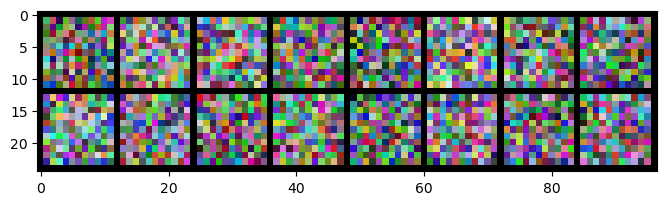

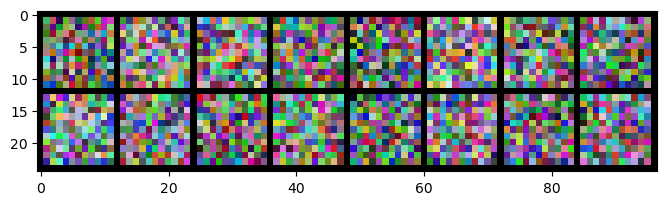

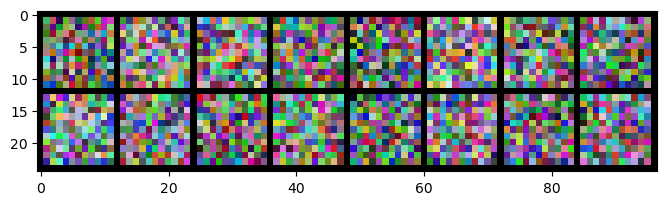

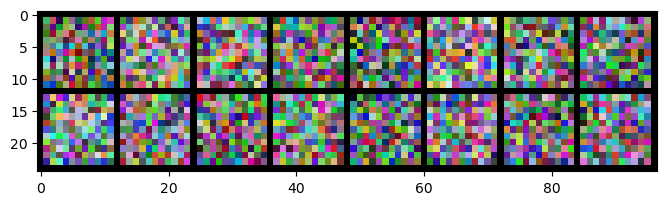

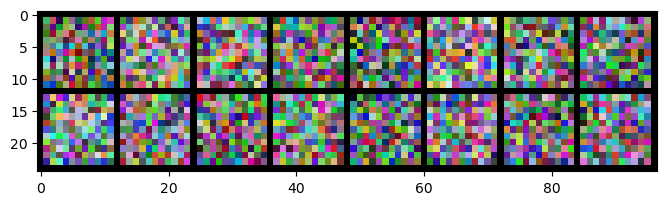

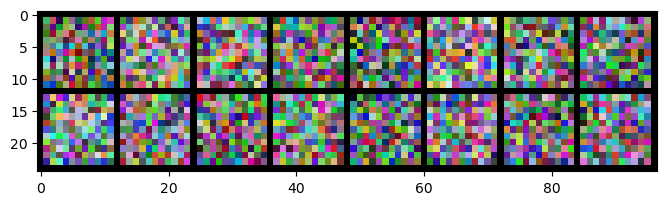

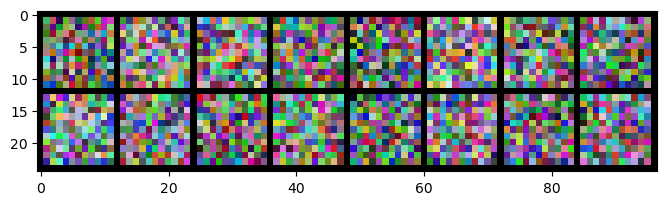

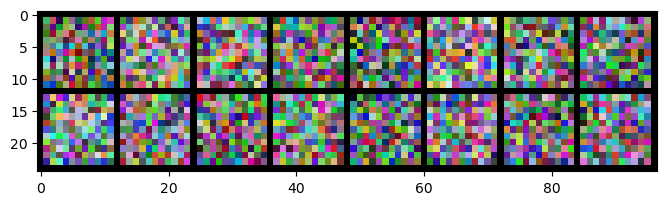

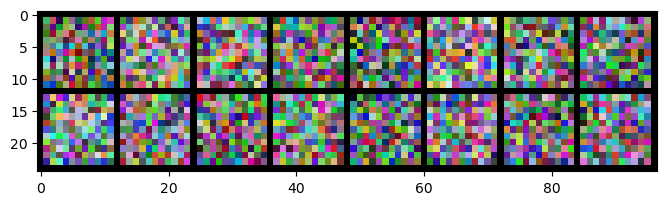

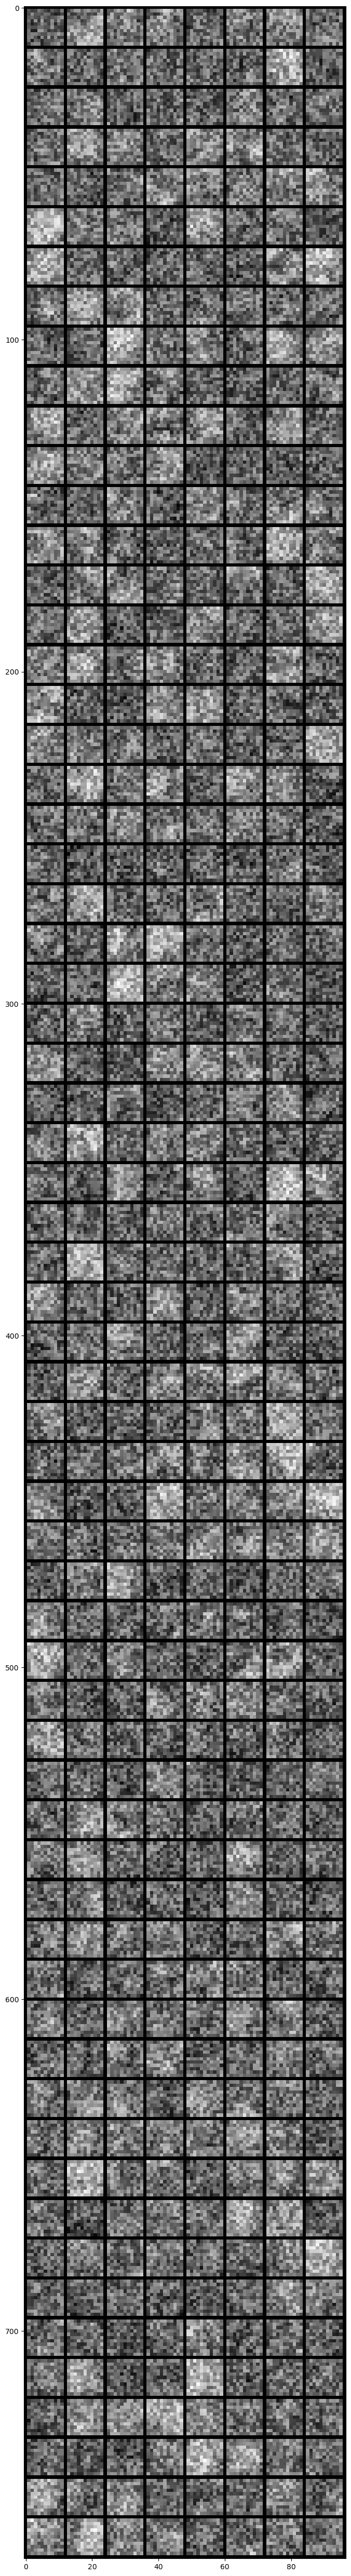

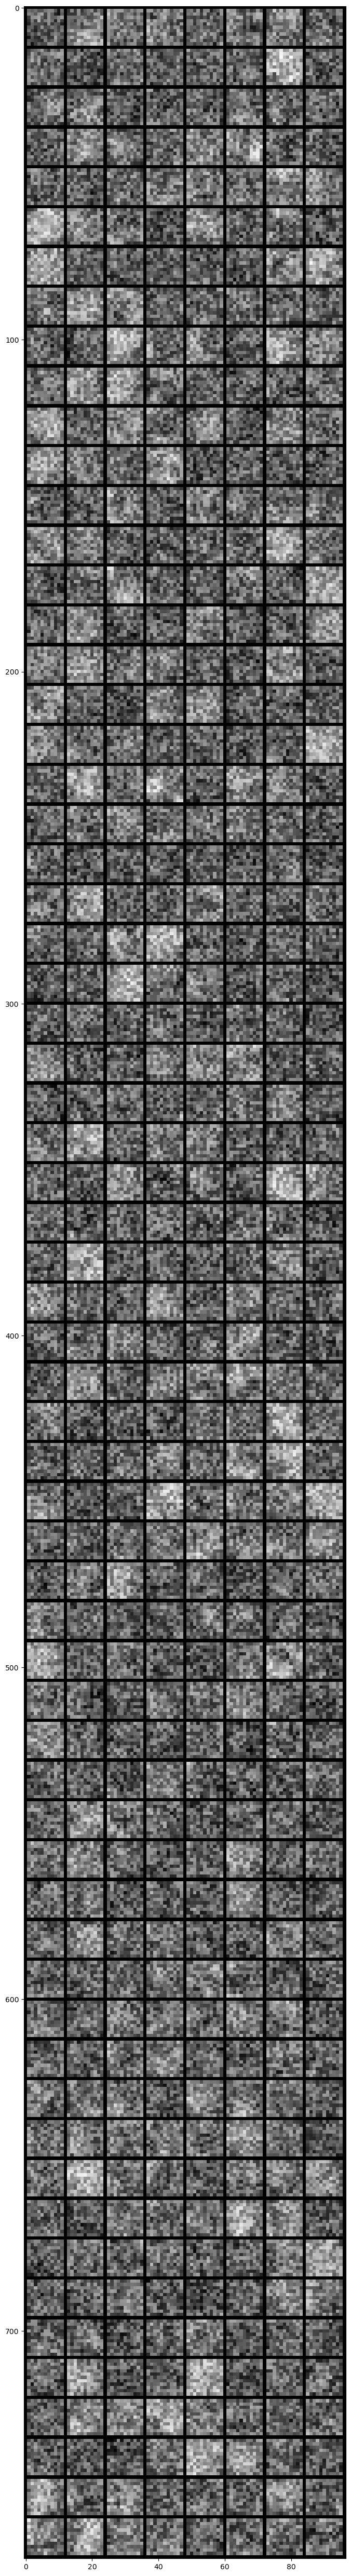

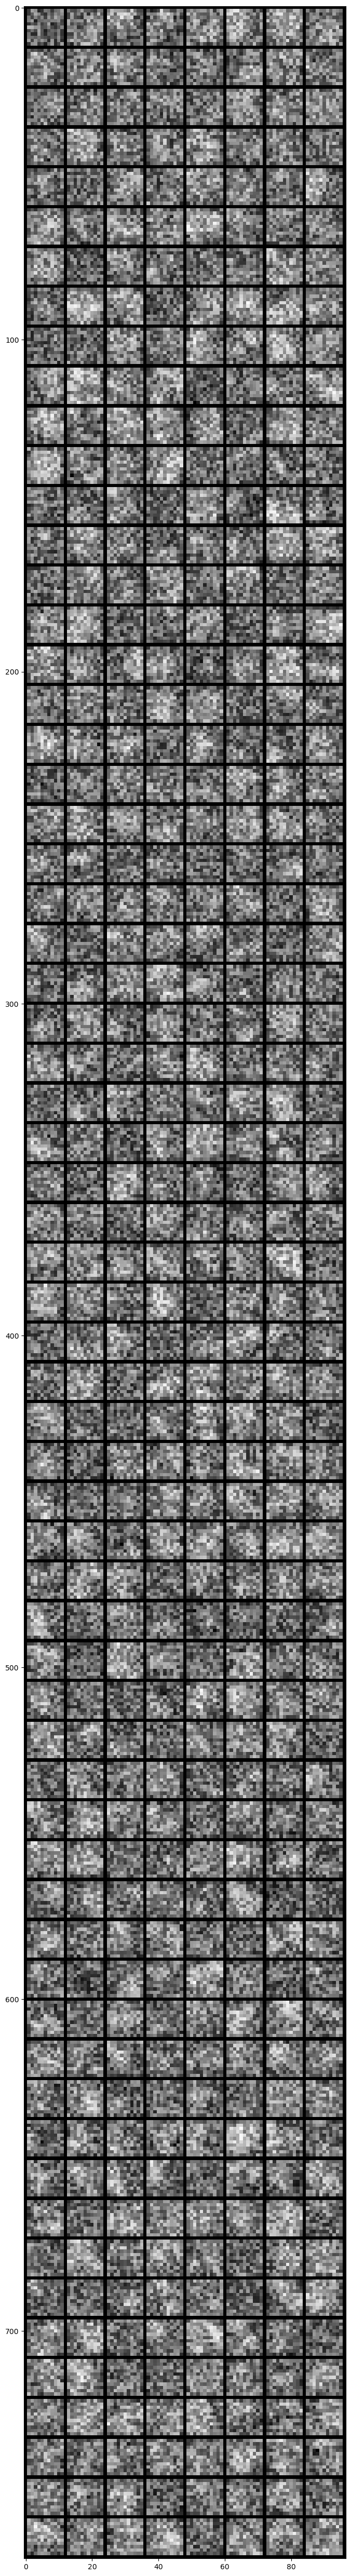

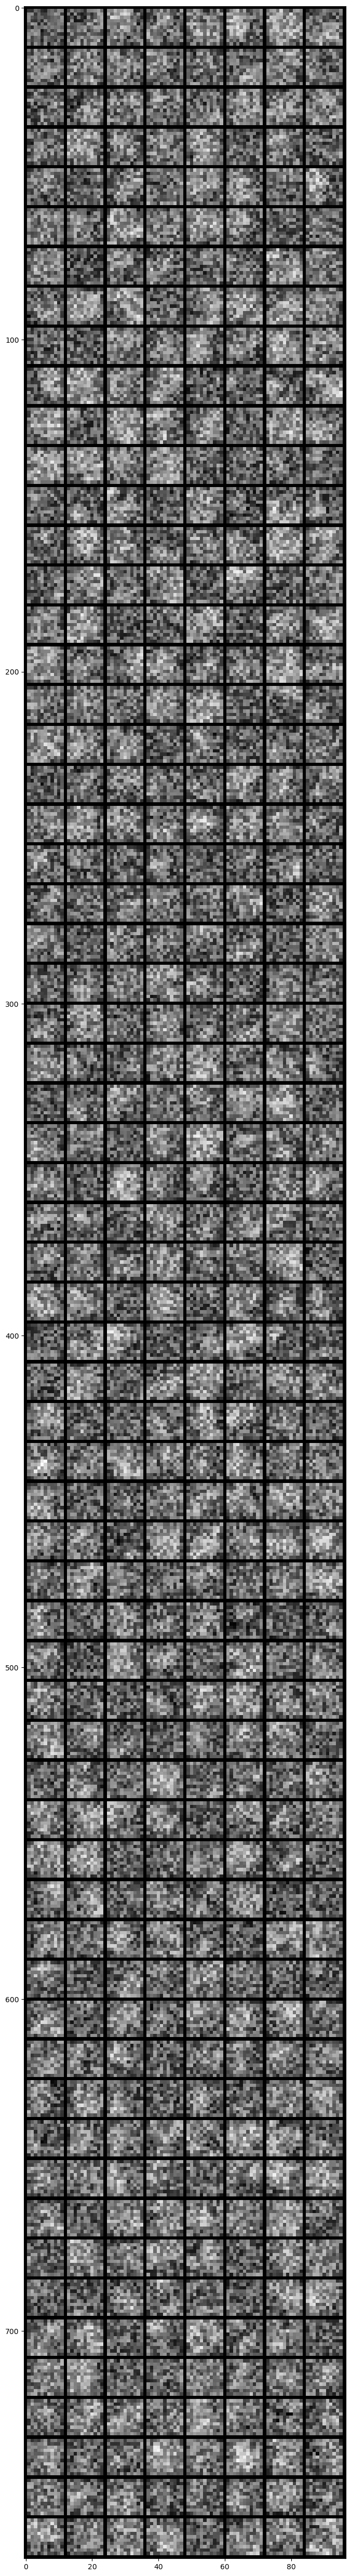

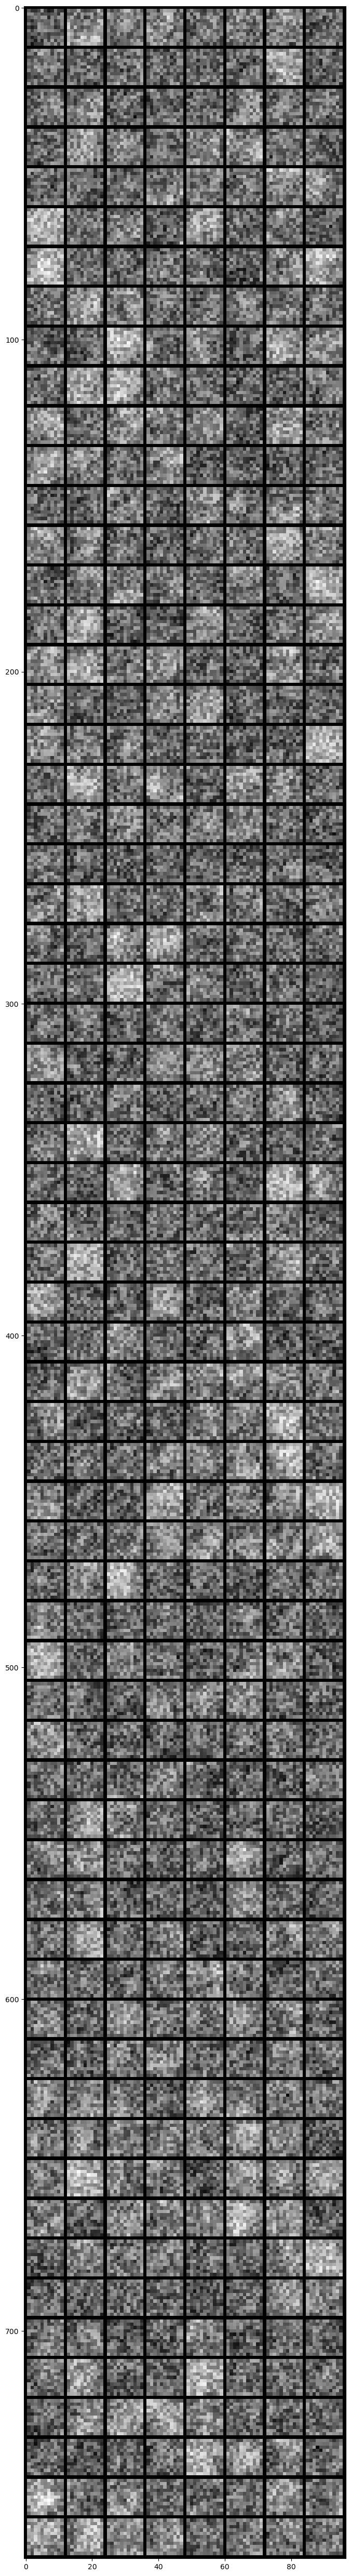

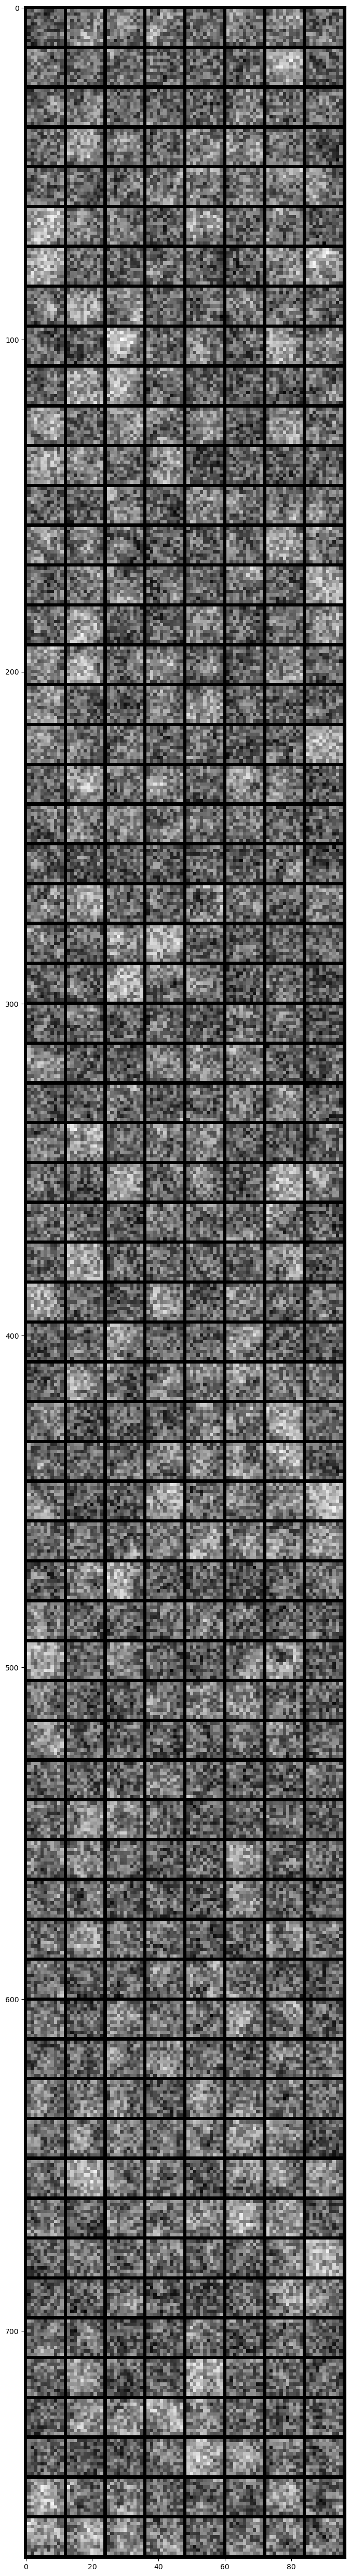

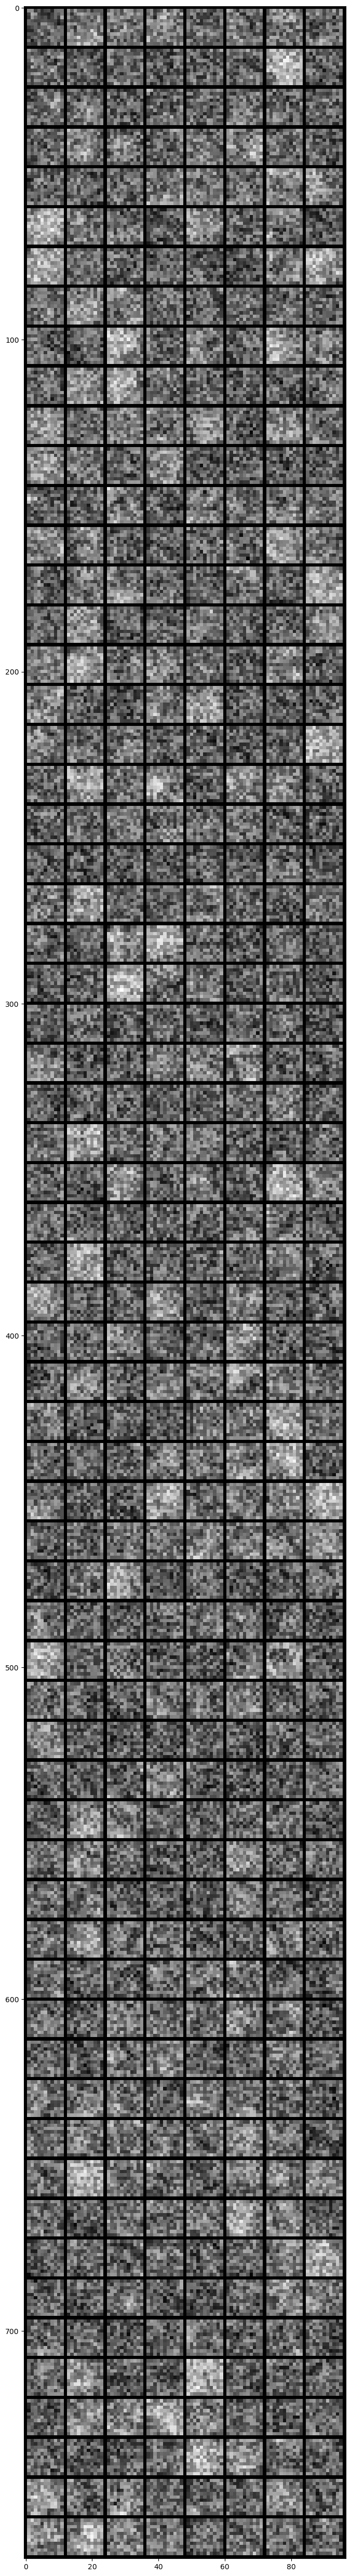

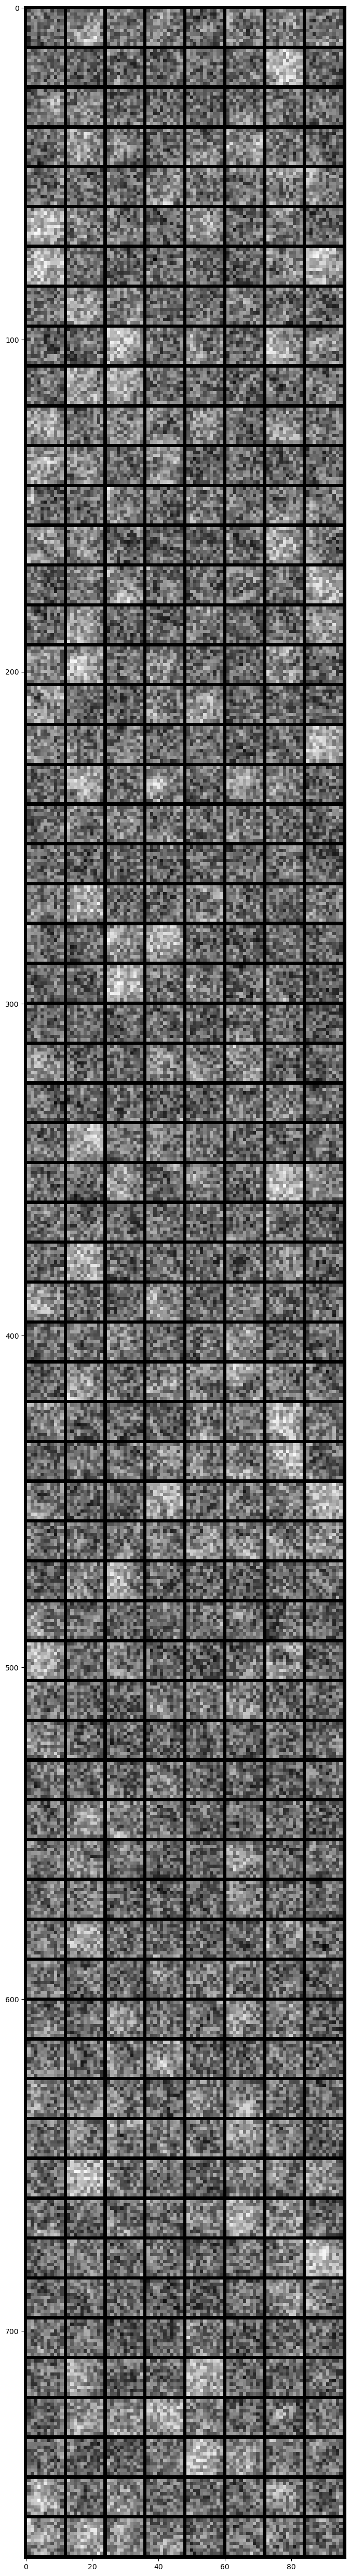

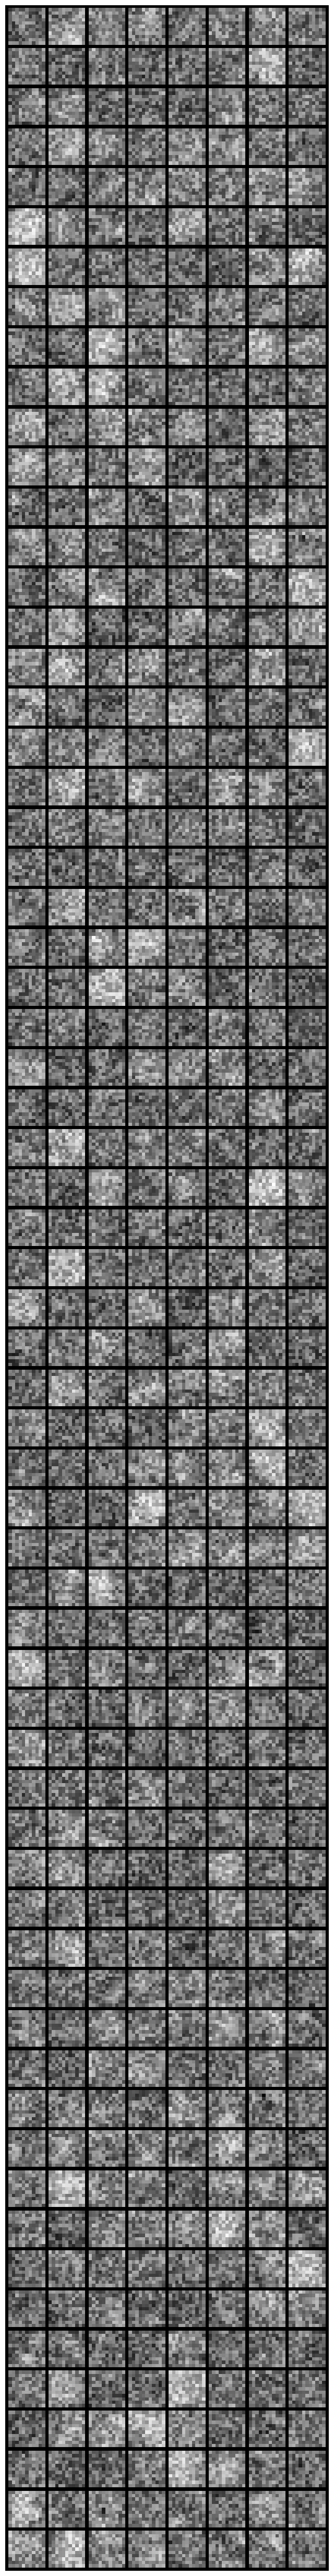

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, h, w)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

up_num = (19*4 + 10)
down_num = (13*4 +7)
feature_num = (up_num*2 + (down_num)*2) +(up_num*2 + down_num)
layer = 1
filters = []
filters.append(model.features[0].weight.to(device='cpu').clone())
filters.append(model.features[feature_num].weight.to(device='cpu').clone())
# filters.append(model.features[9].weight.to(device='cpu').clone())
# filters.append(model.features[14].weight.to(device='cpu').clone())
# filters.append(model.features[18].weight.to(device='cpu').clone())
# filters.append(model.features[23].weight.to(device='cpu').clone())
print(filters[1].size())
# for filter in filters:
#     visTensor(filter, ch=1, allkernels=False)
for el, y in enumerate(filters):
    for x in range(9):
        visTensor(y, ch=x, allkernels=False)
# for x in range(16):
#     visTensor(filters[-1], ch=x, allkernels=True)
# visTensor(filters[2], ch=1, allkernels=False)
plt.axis('off')
plt.ioff()
plt.show()

In [ ]:
max_idx = torch.argmin(torch.tensor(R2s))
R2s[max_idx]

tensor(-2.2985e+14, device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
ads = 1
if not ads:
    print('ds')

In [ ]:
1096*1.7

1863.2

In [ ]:
torch.save(model.state_dict(), '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/best_models/blockwise_noboost.pth')

In [ ]:
best_model_path = '/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/best_models/ModelA_-0.099val.pth'
model.load_state_dict(torch.load(best_model_path))

# Test
test_paths = test_df.image_path.values
test_features = scaler.transform(test_df[FEATURE_COLS].values) 
test_ds = build_dataset(test_paths, test_features, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

c:\Users\Shintaro\anaconda3\envs\pytorch-LLM\Lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
c:\Users\Shintaro\anaconda3\envs\pytorch-LLM\Lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
c:\Users\Shintaro\anaconda3\envs\pytorch-LLM\Lib\site-packages\albumentations\augmentations\dropout\cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [ ]:
model.eval()  # Set the model to evaluation mode

# List to store predictions
all_predictions = []

# Iterate over batches in the test data loader
for batch_idx, inputs_dict in enumerate(tqdm(test_ds, desc='Testing')):
    # Extract images and features from the inputs_dict
    inputs_images = inputs_dict['images'].to(device, dtype=CFG.precision)  # Assuming 'device' is the target device
    inputs_features = inputs_dict['features'].to(device, dtype=CFG.precision)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs_images, inputs_features)

    # Get predictions
    predictions = outputs.cpu().numpy()  # Assuming 'head' is the main task output

    # Append predictions to the list
    all_predictions.append(predictions)

# Concatenate predictions for all batches
all_predictions = np.concatenate(all_predictions, axis=0)

Testing: 100%|██████████| 868/868 [01:06<00:00, 12.98it/s]


In [ ]:
pred_df = test_df[["id"]].copy()
target_cols = [x.replace("_mean","") for x in CFG.class_names]
pred_df[target_cols] = all_predictions.tolist()

sub_df = pd.read_csv(f'{PATH}/sample_submission.csv')
sub_df = sub_df[["id"]].copy()
sub_df = sub_df.merge(pred_df, on="id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

id        X4        X11       X18       X26       X50        X3112
0  195066138  0.521644  13.881434  1.648242  5.785100  1.558604   861.552307
1  195524180  0.526068  13.947787  1.624601  5.760645  1.581069   858.777527
2  172220512  0.493872  16.045834  2.480325  7.894550  1.364580  1158.147217
3  195824490  0.477576  15.220106  2.119382  7.027150  1.319144  1051.645386
4  191793047  0.489437  14.473662  1.702399  5.975630  1.395019   924.626709

In [ ]:
PATH

'/Users/Shintaro/Documents/Kaggle-comps/PlantTraits/Data/planttraits2024'

In [ ]:
hid = out_channels * adaptshape0 *adaptshape1 // (adaptshape0*adaptshape1//patch)**2

In [ ]:
pos = []
for x in range(60,120):
    if (2400*x**2)%1200**2 == 0:
        pos.append(x)

In [ ]:
(2400*pos[0]**2)/1200**2

6.0

In [ ]:
l = 1200/60
l**2

400.0